In [2]:
import os
import pandas as pd
import re
import matplotlib.patches as mpatches
import seaborn as sns
import multiprocessing as mp #
import statsmodels.stats.multitest as multitest
%matplotlib inline


In [3]:
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(ggplot2)

/home/taumata/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


# Make metadata and calculate VJ-frequencies

In [8]:
#filter out samples with less than 2000 clonotypes

## ADAPTIVE

In [ ]:
#Make metadata for vdjtools

In [9]:
med_metadata=pd.read_csv("AB_prediction/adaptive-metadata-edited.tsv",sep="\t")
med_metadata["sample_short_name"]=med_metadata["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names

metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/AB_corr_functional/ncfilter.summary.txt",
                     sep="\t", header=0)

metadata["sample_short_name"]=metadata["sample_id"].apply(lambda x: x[:-13]) #remove _TCRB.tsv.txt from end of names
     

In [10]:
metadata=pd.merge(metadata, med_metadata, how='left', on="sample_short_name",
                 sort=False, validate=None)

In [11]:
out_metadata=metadata.loc[:,["sample_id","sample_short_name","Dataset","COVID-19-status","passed_clones"]]
out_metadata.columns=["#file_name","sample_id","Dataset","COVID-19-status","passed_clones"]
out_metadata["#file_name"]=out_metadata["#file_name"].apply(lambda xT: "AB_corr_functional/"+str(xT))

out_metadata=out_metadata.loc[out_metadata["passed_clones"]>=2000,:]

out_metadata.to_csv("/home/taumata/COV_AdaptiveBiotech_v2/metadata_AB_functional_all_greater2000.txt",
                   sep="\t",index=False,header=True)

In [ ]:
#calculate weighted VJ-usage

In [13]:
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/metadata_AB_functional_all_greater2000.txt", sep="\t")
folder="/home/taumata/COV_AdaptiveBiotech_v2/"

v_usage={}
all_v=set()
for index, row in metadata.iterrows():
    clonoset=pd.read_csv(str(folder)+"/"+str(row[0]), sep="\t")
    sample_v_usage=clonoset.groupby(['v']).sum()
    v_usage[row[0]]=dict(sample_v_usage["freq"])
    all_v=all_v|set(sample_v_usage.index)
    

In [14]:
all_v=list(all_v)
with open("/home/taumata/tcr-association/random_forest_v2/V_usage/Adaptive_corr_func_ALL_greater2000_Vusage.tsv", "w") as out_file:
    out_file.write("sample_id\t"+"\t".join(all_v))
    for sample_name in v_usage:
        out_file.write("\n"+str(sample_name))
        for v_segment in all_v:
            if v_segment in v_usage[sample_name]:
                out_file.write("\t"+str(v_usage[sample_name][v_segment]))
            else:
                out_file.write("\t0")

## HIP

In [ ]:
#Make metadata for vdjtools

In [15]:
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/hip_corr_func/ncfilter.summary.txt",
                     sep="\t", header=0)

metadata["#file_name"]=metadata["sample_id"].apply(lambda x: str(x)+".txt") #remove _TCRB.tsv.txt from end of names
metadata["Dataset"]=metadata["sample_id"].apply(lambda x: "HIP" if x.startswith("HIP") else "KECK")              
    
out_metadata=metadata.loc[:,["#file_name","sample_id","Dataset","passed_clones"]]
out_metadata=out_metadata.loc[out_metadata["passed_clones"]>=2000,:]
out_metadata["#file_name"]=out_metadata["#file_name"].apply(lambda xT: "hip_corr_func/"+str(xT))

out_metadata.to_csv("/home/taumata/COV_AdaptiveBiotech_v2/metadata_HIP_functional_all_greater2000.txt",
                   sep="\t",index=False,header=True)


In [16]:
#calculate VJ-usage

In [17]:
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/metadata_HIP_functional_all_greater2000.txt", sep="\t")
folder="/home/taumata/COV_AdaptiveBiotech_v2/"

v_usage={}
all_v=set()
for index, row in metadata.iterrows():
    clonoset=pd.read_csv(str(folder)+"/"+str(row[0]), sep="\t")
    sample_v_usage=clonoset.groupby(['v']).sum()
    v_usage[row[0]]=dict(sample_v_usage["freq"])
    all_v=all_v|set(sample_v_usage.index)

In [18]:
all_v=list(all_v)
with open("/home/taumata/tcr-association/random_forest_v2/V_usage/HIP_corr_func_ALL_greater2000_Vusage.tsv", "w") as out_file:
    out_file.write("sample_id\t"+"\t".join(all_v))
    for sample_name in v_usage:
        out_file.write("\n"+str(sample_name))
        for v_segment in all_v:
            if v_segment in v_usage[sample_name]:
                out_file.write("\t"+str(v_usage[sample_name][v_segment]))
            else:
                out_file.write("\t0")

## FMBA

In [ ]:
#Make metadata for vdjtools

In [167]:
def take_functional_and_filter_small_samples(inFile,outFile,N=2000):
    #-----read input file----
    tcr_input=pd.read_csv(inFile,
                         sep="\t")
    #-----check header-------
    if tcr_input.columns[0]!="count":
        print("proplems with file "+str(inFile)+ "  (not vdjtools formated?)")
        return "bad file?" +str(inFile)
    #-----check number of functional clonotypes
    tcr_input=tcr_input.loc[~tcr_input["cdr3aa"].str.contains("\*|_")]
    if tcr_input.shape[0]<N:
        print("not enougth clonotypes in "+str(inFile))
        return "not enougth clonotypes in "+str(inFile)    
    tcr_input=tcr_input.sort_values(by="count", ascending=False) #sort by counts "back" 
    #-----adjust frquencies in subset table (make them sum to 1)
    tcr_input.loc[:,"freq"]=tcr_input["count"]/tcr_input["count"].sum()
    #-----save subsampled table to file
    tcr_input.to_csv(outFile,index=False,sep="\t")
    return "good"


In [169]:
number_of_TCRs=2000

metadata=pd.read_csv("/projects/fmba_covid/fmba_upd_march/metadata.txt", sep="\t")
normal_size_sammples=[file_name for file_name in metadata["file.name"] if re.search("TRB",file_name)]

input_folder="/projects/fmba_covid/fmba_upd_march/data"
output_folder="/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_Reseq_func"

#---make output folder
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass


#--define function wrapper for takeTopAA
def takeTOP_wrap(sample_id, input_folder=input_folder, output_folder=output_folder,
                            number_of_TCRs=number_of_TCRs):
    result=take_functional_and_filter_small_samples(str(input_folder) +"/"+str(sample_id),
                             str(output_folder)+"/"+str(sample_id),
                             number_of_TCRs)
    return (sample_id, result)

#--run multiprocess                                   
print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(takeTOP_wrap, normal_size_sammples)
pool.close()
good_or_bad=dict(results)
print("DONE")

#--make metadata file
with open(str(output_folder)+"/metadata.txt","w") as meta_file:
    for sample_id in good_or_bad:
        if good_or_bad[sample_id]=="good":
            meta_file.write(str(sample_id)+"\n")
        else:
            print(good_or_bad[sample_id])
        
        
        

/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_Reseq_func
START
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/020000640808_S117_L002.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/330001780808_S170_L002.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/050001980808_S62_L001.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/050002130808_S46_L001.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/250002490808_S110_L002.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/050002030808_S38_L001.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/340003730808_S21_L001.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/400000110808_S150_L002.clonotypes.TRB.txt
not enougth clonotypes in /projects/fmba_covid/fmba_upd_march/data/26

In [170]:
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_Reseq_func/metadata.txt", sep="\t",
                    header=None)
folder="/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_Reseq_func"

v_usage={}
all_v=set()
for index, row in metadata.iterrows():
    clonoset=pd.read_csv(str(folder)+"/"+str(row[0]), sep="\t")
    sample_v_usage=clonoset.groupby(['v']).sum()
    v_usage[row[0]]=dict(sample_v_usage["freq"])
    all_v=all_v|set(sample_v_usage.index)

In [171]:
all_v=list(all_v)
with open("/home/taumata/tcr-association/random_forest_v2/V_usage/FMBA_Reseq_func_Vusage.tsv", "w") as out_file:
    out_file.write("sample_id\t"+"\t".join(all_v))
    for sample_name in v_usage:
        out_file.write("\n"+str(sample_name))
        for v_segment in all_v:
            if v_segment in v_usage[sample_name]:
                out_file.write("\t"+str(v_usage[sample_name][v_segment]))
            else:
                out_file.write("\t0")

# Read "batch" clonotypes 

In [6]:
#HIP/KECK
hip_keck=pd.read_csv("/home/taumata/random_forest_v2/V_usage/HIP_corr_func_ALL_greater2000_Vusage.tsv",sep="\t")


In [7]:
hip_keck.columns


Index(['sample_id', 'TRBV28', 'TRBV8-2', 'TRBV11-2', 'TRBV4-3', 'TRBV7-6',
       'TRBV5-8', 'TRBV29-1', 'TRBV16', 'TRBV7-1', 'TRBV20-1', 'TRBV2',
       'TRBV5-2', 'TRAV3', 'TRBV12-3', 'TRBV7-2', 'TRBV7-9', 'TRBV1', 'TRBV19',
       'TRBV5-4', 'TRBV5-1', 'TRBV5-7', 'TRBV3-1', 'TRBV6-5', 'TRBV21-1',
       'TRBV12-4', 'TRBV6-8', 'TRBV7-8', 'TRBV12-5', 'TRBV14', 'TRBV5-3',
       'TRBV5-5', 'TRBV10-2', 'TRBV15', 'TRBV6-7', 'TRBV24-1', 'TRBV3-2',
       'TRBV11-1', 'TRBV12-1', 'TRBV6-1', 'TRBV13', 'TRBV10-1', 'TRBV26',
       'TRAV16', 'TRBV25-1', 'TRBV17', 'TRBV10-3', 'TRBV7-5', 'TRAV20',
       'TRBV23-1', 'TRBV6-9', 'TRBV30', 'TRBV9', 'TRBV4-1', 'TRBV7-3',
       'TRBV11-3', 'TRBV22-1', 'TRBV6-4', 'TRBV6-6', 'TRBV18', 'TRBV7-4',
       'TRBV27', 'TRBV6-3', 'TRBV7-7', 'TRBV4-2', 'TRBV12-2', 'TRBV5-6'],
      dtype='object')

In [8]:
#copy columns with general metadata
hip_keck_colapse=hip_keck.loc[:,['sample_id', 'Dataset', 'passed_clones']]
#copy columns with TRBV that do not have subfamilies
hip_keck_colapse=pd.concat([hip_keck_colapse,
                           hip_keck.loc[:,[xT for xT in hip_keck.columns if xT.startswith("TRBV") & (re.search("-",xT)==None)]]], axis=1)
#sum all TRBV from different subfamilies of same family
for trbv in set([xT.split("-")[0] for xT in hip_keck.columns if xT.startswith("TRBV") & (re.search("-",xT)!=None)]):
    #print(trbv)
    #print(hip_keck.loc[:,[xT for xT in hip_keck.columns if re.search(str(trbv)+"-",xT)!=None]].columns)
    hip_keck_colapse[trbv]=hip_keck.loc[:,[xT for xT in hip_keck.columns if re.search(str(trbv)+"-",xT)!=None]].sum(axis=1)
 

/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [9]:
#ADAPTIVE
adaptive=pd.read_csv("/home/taumata/random_forest_v2/V_usage/Adaptive_corr_func_ALL_greater2000_Vusage.tsv",sep="\t")


In [10]:
adaptive.head()


,sample_id,TRBV28,TRBV8-2,TRBV11-2,TRBV4-3,TRBV7-6,TRBV5-8,TRBV29-1,TRBV16,TRBV7-1,...,TRBV6-4,TRBV6-6,TRBV18,TRBV7-4,TRBV27,TRBV6-3,TRBV7-7,TRBV4-2,TRBV12-2,TRBV5-6
0,AB_corr_functional/KH20-09976_TCRB.tsv.txt,0.005092,0.000000,0.201286,0.003942,0.003274,0.004112,0.028738,0.000191,0.000000,...,0.004528,0.011109,0.014777,0.000106,0.020154,0.011036,0.002361,0.004087,0.000357,0.012492
1,AB_corr_functional/550044028_TCRB.tsv.txt,0.051294,0.000003,0.023528,0.013187,0.006527,0.002846,0.021370,0.000872,0.000005,...,0.006506,0.018536,0.022609,0.000125,0.022446,0.020050,0.006802,0.007223,0.000640,0.016108
2,AB_corr_functional/860011242_TCRB.tsv.txt,0.004987,0.000000,0.021069,0.029286,0.007222,0.006585,0.027852,0.001372,0.000000,...,0.005298,0.018608,0.035286,0.000670,0.017592,0.034851,0.004914,0.004071,0.000453,0.019637
3,AB_corr_functional/1024_TCRB.tsv.txt,0.060100,0.000000,0.017766,0.012506,0.007648,0.005168,0.014249,0.000650,0.000000,...,0.006342,0.012736,0.029863,0.000092,0.170470,0.018911,0.003562,0.009950,0.000414,0.037575
4,AB_corr_functional/INCOV045-BL-3_TCRB.tsv.txt,0.078499,0.000000,0.020516,0.023543,0.006640,0.005391,0.021408,0.000979,0.000002,...,0.009925,0.019394,0.029161,0.000186,0.058614,0.038066,0.005236,0.008326,0.000456,0.015258


In [11]:
#copy columns with general metadata
adaptive_colapse=adaptive.loc[:,['sample_id', 'Dataset', 'COVID-19-status', 'passed_clones']]
#copy columns with TRBV that do not have subfamilies
adaptive_colapse=pd.concat([adaptive_colapse,
                           adaptive.loc[:,[xT for xT in adaptive.columns if xT.startswith("TRBV") & (re.search("-",xT)==None)]]], axis=1)
#sum all TRBV from different subfamilies of same family
for trbv in set([xT.split("-")[0] for xT in adaptive.columns if xT.startswith("TRBV") & (re.search("-",xT)!=None)]):
    #print(trbv)
    #print(hip_keck.loc[:,[xT for xT in hip_keck.columns if re.search(str(trbv)+"-",xT)!=None]].columns)
    adaptive_colapse[trbv]=adaptive.loc[:,[xT for xT in adaptive.columns if re.search(str(trbv)+"-",xT)!=None]].sum(axis=1)
 

In [12]:
#FMBA
fmba=pd.read_csv("/home/taumata/random_forest_v2/V_usage/FMBA_Reseq_func_Vusage.tsv",sep="\t")


In [13]:
fmba.head()


,sample_id,TRBV28,TRBV11-2,TRBV4-3,TRBV7-6,TRBV5-8,TRBV29-1,TRBV16,TRBV7-1,TRBV20-1,...,TRBV6-4,TRBV6-6,TRBV18,TRBV7-4,TRBV27,TRBV7-7,TRBV6-3,TRBV4-2,TRBV12-2,TRBV5-6
0,020000010808_S3_L001.clonotypes.TRB.txt,0.008358,0.005429,0.000002,0.013454,0.007594,0.009323,0.0,0.0,0.089446,...,0.056809,0.022643,0.005333,0.000025,0.037504,0.003485,0.000000,0.008376,0.000016,0.009949
1,020000110808_S14_L001.clonotypes.TRB.txt,0.054467,0.010657,0.007444,0.038321,0.006884,0.006750,0.0,0.0,0.046358,...,0.011487,0.029478,0.008324,0.000088,0.068798,0.002567,0.000000,0.003841,0.000239,0.016797
2,020000190808_S27_L001.clonotypes.TRB.txt,0.085239,0.008438,0.009761,0.018322,0.005362,0.007639,0.0,0.0,0.061770,...,0.018083,0.020873,0.018130,0.000116,0.050386,0.002619,0.000209,0.007926,0.000354,0.014636
3,020000200808_S181_L002.clonotypes.TRB.txt,0.107074,0.008655,0.015207,0.013124,0.007250,0.006970,0.0,0.0,0.043082,...,0.010927,0.026726,0.012677,0.000292,0.053186,0.001391,0.000000,0.024684,0.000202,0.021751
4,020000280808_S59_L001.clonotypes.TRB.txt,0.015818,0.008775,0.076424,0.011373,0.005086,0.008594,0.0,0.0,0.087214,...,0.003806,0.031411,0.004858,0.000000,0.039564,0.001419,0.000000,0.007998,0.000195,0.026495


In [17]:
FMBA_metadata=pd.read_csv("/projects/fmba_covid/fmba_upd_march/metadata.txt",
                          sep="\t",header=0, dtype=str)
FMBA_metadata=FMBA_metadata.rename(columns={"file.name": "sample_id"})

fmba_with_status=pd.merge(fmba,
                          FMBA_metadata.loc[:,["sample_id","COVID_status"]],
                          on="sample_id",how="left")
                                                  
#copy columns with general metadata
fmba_colapse=fmba_with_status.loc[:,['sample_id', 'Dataset' ,"COVID_status"]]
#copy columns with TRBV that do not have subfamilies
fmba_colapse=pd.concat([fmba_colapse,
                        fmba_with_status.loc[:,[xT for xT in fmba_with_status.columns if xT.startswith("TRBV") & (re.search("-",xT)==None)]]], axis=1)
#sum all TRBV from different subfamilies of same family
for trbv in set([xT.split("-")[0] for xT in fmba_with_status.columns if xT.startswith("TRBV") & (re.search("-",xT)!=None)]):
    #print(trbv)
    #print(hip_keck.loc[:,[xT for xT in hip_keck.columns if re.search(str(trbv)+"-",xT)!=None]].columns)
    fmba_colapse[trbv]=fmba_with_status.loc[:,[xT for xT in fmba_with_status.columns if re.search(str(trbv)+"-",xT)!=None]].sum(axis=1)
    

fmba_colapse=fmba_colapse.rename(columns={"COVID_status": "COVID-19-status"})
fmba_colapse.head()                         

,sample_id,Dataset,COVID-19-status,TRBV28,TRBV16,TRBV2,TRBV19,TRBV14,TRBV15,TRBV13,...,TRBV12,TRBV7,TRBV23,TRBV3,TRBV6,TRBV10,TRBV4,TRBV20,TRBV11,TRBV5
0,020000010808_S3_L001.clonotypes.TRB.txt,NaN,COVID,0.008358,0.0,0.002605,0.016101,0.005558,0.000034,0.003898,...,0.063609,0.068287,0.001982,0.005268,0.245889,0.081185,0.014571,0.089446,0.007955,0.212031
1,020000110808_S14_L001.clonotypes.TRB.txt,NaN,COVID,0.054467,0.0,0.004078,0.020023,0.007132,0.000235,0.002632,...,0.123130,0.121669,0.012176,0.000842,0.171672,0.171347,0.016397,0.046358,0.014717,0.097891
2,020000190808_S27_L001.clonotypes.TRB.txt,NaN,COVID,0.085239,0.0,0.017496,0.018542,0.012562,0.000178,0.003321,...,0.186661,0.106681,0.008878,0.002328,0.201598,0.027267,0.024314,0.061770,0.011994,0.080797
3,020000200808_S181_L002.clonotypes.TRB.txt,NaN,healthy,0.107074,0.0,0.012381,0.016462,0.010077,0.000164,0.004784,...,0.087441,0.093255,0.005797,0.002094,0.267886,0.040369,0.046368,0.043082,0.012528,0.107259
4,020000280808_S59_L001.clonotypes.TRB.txt,NaN,COVID,0.015818,0.0,0.001387,0.033648,0.005163,0.000044,0.002071,...,0.129699,0.118727,0.003992,0.000604,0.180615,0.117235,0.091249,0.087214,0.013342,0.094639


In [14]:
VIP=pd.read_csv("/home/taumata/random_forest_v2/V_usage/FMBA_VIP_Vusage.tsv",sep="\t")
VIP.head()


,sample_id,TRBV21-1,TRBV6-1,TRBV12-3,TRBV3-1,TRBV29-1,TRBV30,TRBV14,TRBV4-2,TRBV3-2,...,TRBV12-1,TRBV5-4,TRBV5-6,TRBV6-4,TRBV6-6,TRBV7-2,TRBV7-4,TRBV7-9,TRBV11-3,TRBV6-5
0,/home/taumata/COV_VIP/VIP-ID770500780101-TRAB-...,0.002733,0.047586,0.005045,0.000306,0.003185,0.004213,0.014769,0.011738,0.000016,...,0.000159,0.018150,0.012526,0.008981,0.023387,0.036109,0.000404,0.024174,0.002704,0.047537
1,/home/taumata/COV_VIP/VIP-ID770500800101-TRAB-...,0.002637,0.061667,0.044909,0.000321,0.002120,0.003036,0.021443,0.010916,0.000018,...,0.000142,0.021795,0.019464,0.009712,0.027386,0.038998,0.000472,0.022418,0.002999,0.077299
2,/home/taumata/COV_VIP/VIP-ID770500810101-TRAB-...,0.006045,0.038882,0.014199,0.000291,0.002101,0.006195,0.012933,0.008261,0.000249,...,0.000436,0.015335,0.015714,0.031868,0.026569,0.041625,0.000119,0.024798,0.002525,0.054259
3,/home/taumata/COV_VIP/VIP98-new-mix-TRAB-DNA_S...,0.005344,0.023044,0.067804,0.019834,0.005631,0.009038,0.021770,0.010060,0.000592,...,0.000179,0.051198,0.025464,0.004411,0.087691,0.035507,0.000215,0.071103,0.008536,0.029966
4,/home/taumata/COV_VIP/VIP97-new-mix-TRAB-DNA_S...,0.006500,0.020583,0.077906,0.015607,0.003819,0.008538,0.008391,0.027376,0.004333,...,0.000294,0.027872,0.023282,0.020620,0.012853,0.049538,0.000330,0.061326,0.004076,0.039807


In [30]:

VIP_colapse=VIP.loc[:,['sample_id']]
VIP_colapse['Dataset']="VIP"
VIP_colapse['COVID-19-status']="VIP"
#copy columns with TRBV that do not have subfamilies
VIP_colapse=pd.concat([VIP_colapse,
                        VIP.loc[:,[xT for xT in VIP.columns if xT.startswith("TRBV") & (re.search("-",xT)==None)]]], axis=1)
#sum all TRBV from different subfamilies of same family
for trbv in set([xT.split("-")[0] for xT in VIP.columns if xT.startswith("TRBV") & (re.search("-",xT)!=None)]):
    #print(trbv)
    #print(hip_keck.loc[:,[xT for xT in hip_keck.columns if re.search(str(trbv)+"-",xT)!=None]].columns)
    VIP_colapse[trbv]=VIP.loc[:,[xT for xT in VIP.columns if re.search(str(trbv)+"-",xT)!=None]].sum(axis=1)
    

In [31]:
VIP_colapse

,sample_id,Dataset,COVID-19-status,TRBV30,TRBV14,TRBV9,TRBV18,TRBV28,TRBV13,TRBV15,...,TRBV12,TRBV7,TRBV11,TRBV23,TRBV6,TRBV10,TRBV4,TRBV20,TRBV3,TRBV5
0,/home/taumata/COV_VIP/VIP-ID770500780101-TRAB-...,VIP,VIP,0.004213,0.014769,0.167895,0.018754,0.068934,0.002166,0.000220,...,0.060964,0.100193,0.012305,0.005433,0.166451,0.026956,0.031777,0.036468,0.000322,0.115386
1,/home/taumata/COV_VIP/VIP-ID770500800101-TRAB-...,VIP,VIP,0.003036,0.021443,0.033077,0.017235,0.051919,0.008237,0.000197,...,0.076745,0.103481,0.015833,0.002834,0.263514,0.020005,0.045394,0.017862,0.000339,0.132964
2,/home/taumata/COV_VIP/VIP-ID770500810101-TRAB-...,VIP,VIP,0.006195,0.012933,0.067100,0.012986,0.036862,0.003497,0.000218,...,0.087842,0.106472,0.013066,0.003313,0.284267,0.041292,0.045838,0.019288,0.000539,0.096546
3,/home/taumata/COV_VIP/VIP98-new-mix-TRAB-DNA_S...,VIP,VIP,0.009038,0.021770,0.047307,0.019726,0.021806,0.004914,0.000574,...,0.130640,0.145936,0.021358,0.002134,0.159619,0.031077,0.036027,0.022757,0.020425,0.136342
4,/home/taumata/COV_VIP/VIP97-new-mix-TRAB-DNA_S...,VIP,VIP,0.008538,0.008391,0.074528,0.019463,0.024585,0.005178,0.000679,...,0.116317,0.152232,0.017498,0.003434,0.137635,0.028607,0.077796,0.031893,0.019940,0.111121
5,/home/taumata/COV_VIP/VIP-ID770500770101-TRAB-...,VIP,VIP,0.003372,0.033001,0.037098,0.009666,0.024646,0.001395,0.000195,...,0.060840,0.213638,0.068887,0.001718,0.109442,0.027285,0.038629,0.021066,0.001280,0.157773
6,/home/taumata/COV_VIP/VIP-ID770500980102-TRAB-...,VIP,VIP,0.003989,0.040857,0.025869,0.015530,0.016250,0.001580,0.000107,...,0.083587,0.101481,0.015790,0.003214,0.313279,0.035755,0.027004,0.014059,0.000499,0.107438
7,/home/taumata/COV_VIP/VIP82-new-mix-TRAB-DNA_S...,VIP,VIP,0.009605,0.006579,0.065226,0.012387,0.010940,0.010733,0.000714,...,0.108835,0.157538,0.017895,0.008684,0.095113,0.043327,0.077707,0.022688,0.019925,0.180940
8,/home/taumata/COV_VIP/VIP-ID770500820101-TRAB-...,VIP,VIP,0.004626,0.012174,0.047973,0.011702,0.007665,0.005428,0.000149,...,0.079356,0.162112,0.014278,0.010645,0.213006,0.048587,0.059819,0.014558,0.000413,0.142465
9,/home/taumata/COV_VIP/VIP-ID770500970102-TRAB-...,VIP,VIP,0.004076,0.013741,0.048342,0.016053,0.015792,0.002623,0.000091,...,0.078899,0.119783,0.014741,0.004485,0.286889,0.036137,0.059105,0.021370,0.000376,0.098458


## Combine and plot V-usage of all samples

In [18]:
hip_keck_colapse["COVID-19-status"]="healthy"

hip_keck_colapse["sample_id"]=[xT.split("/")[-1] for xT in hip_keck_colapse["sample_id"]]
adaptive_colapse["sample_id"]=[xT.split("/")[-1] for xT in adaptive_colapse["sample_id"]]

In [19]:
hip_keck_colapse["Dataset"]=hip_keck_colapse["sample_id"].apply(lambda x: "HIP" if x.startswith("HIP") else "KECK") 
adaptive_colapse["Dataset"]="AB"
fmba_colapse["Dataset"]="FMBA"



In [32]:
all_samples_V_usage=pd.concat([hip_keck_colapse,adaptive_colapse,fmba_colapse,VIP_colapse],sort=True)


In [33]:
all_samples_V_usage=all_samples_V_usage.fillna(0)


In [34]:
all_samples_V_usage.head()


,COVID-19-status,Dataset,TRBV1,TRBV10,TRBV11,TRBV12,TRBV13,TRBV14,TRBV15,TRBV16,...,TRBV3,TRBV30,TRBV4,TRBV5,TRBV6,TRBV7,TRBV8,TRBV9,passed_clones,sample_id
0,healthy,HIP,0.000449,0.051211,0.022284,0.046864,0.006842,0.005234,0.007433,0.000414,...,0.064872,0.033444,0.036462,0.155844,0.205575,0.099032,0.000003,0.035585,0.0,HIP00110.txt
1,healthy,HIP,0.000219,0.028262,0.032249,0.053732,0.007799,0.006389,0.009033,0.000590,...,0.024546,0.029365,0.065225,0.132809,0.269106,0.088479,0.000000,0.019684,0.0,HIP00169.txt
2,healthy,HIP,0.000654,0.045662,0.026695,0.061774,0.017991,0.018373,0.016286,0.000565,...,0.039535,0.026230,0.058303,0.121794,0.169984,0.102725,0.000000,0.015977,0.0,HIP00594.txt
3,healthy,HIP,0.000279,0.024112,0.033620,0.038890,0.006319,0.012408,0.002740,0.000926,...,0.034832,0.009509,0.100102,0.117285,0.181426,0.118267,0.000000,0.020968,0.0,HIP00602.txt
4,healthy,HIP,0.000608,0.028651,0.018494,0.031434,0.007857,0.011247,0.014666,0.000858,...,0.031680,0.022361,0.057954,0.065439,0.287723,0.109303,0.000000,0.024376,0.0,HIP00614.txt


In [35]:
#PLOT
v_usage_to_plot=all_samples_V_usage.drop(columns=["sample_id","COVID-19-status",
                                                 "Dataset","passed_clones"])


labels=list(all_samples_V_usage["Dataset"])
sample_id=list(all_samples_V_usage["sample_id"])


v_usage_to_plot.index=sample_id


lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(labels)
row_colors[0]=list(map(lambda x: (lut[x]), row_colors[0]))
row_colors.index=sample_id


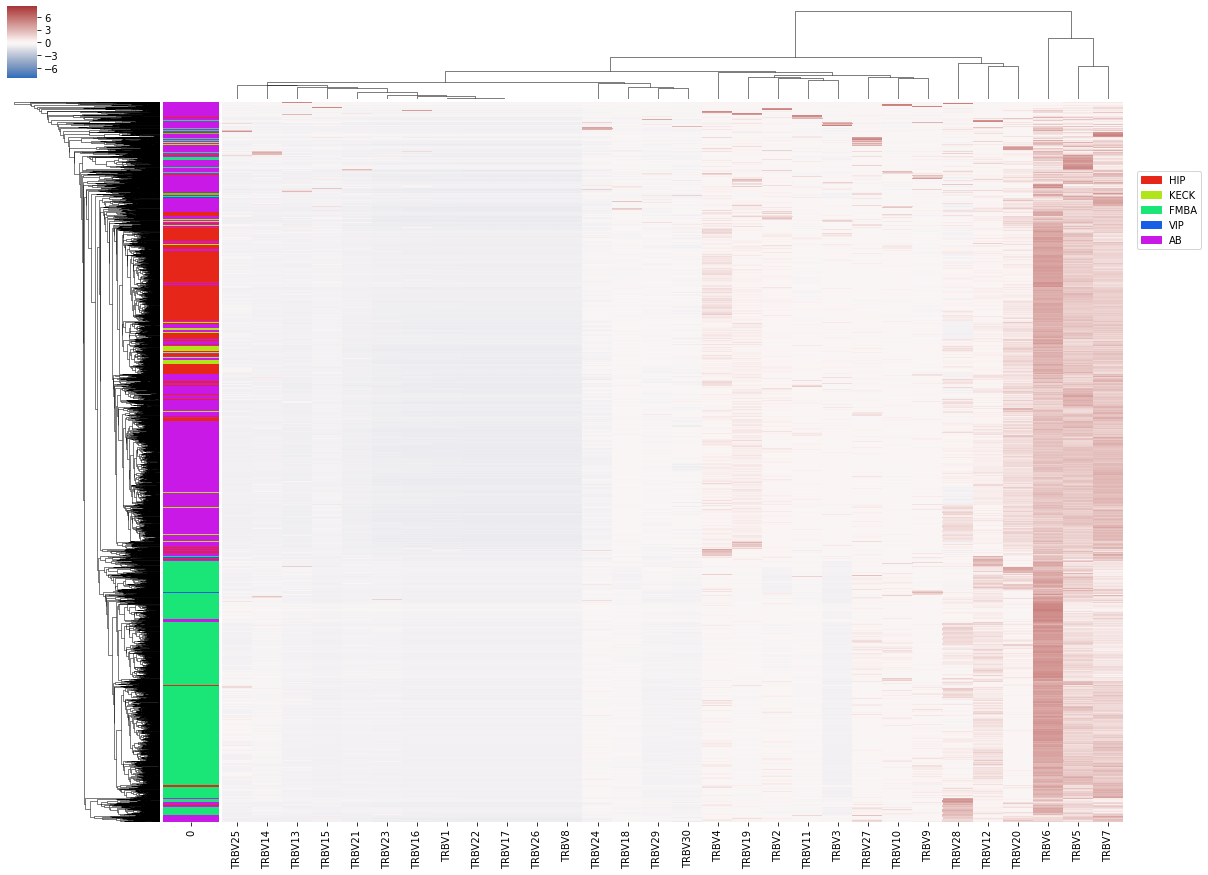

In [36]:
legend_TN = [mpatches.Patch(color=lut[l], label=l) for l in set(labels)]

g=sns.clustermap(v_usage_to_plot,figsize=(20, 15),row_colors=row_colors,cmap="vlag", vmin=-8.5, vmax=8.5,
              yticklabels=False,z_score=0)

g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)


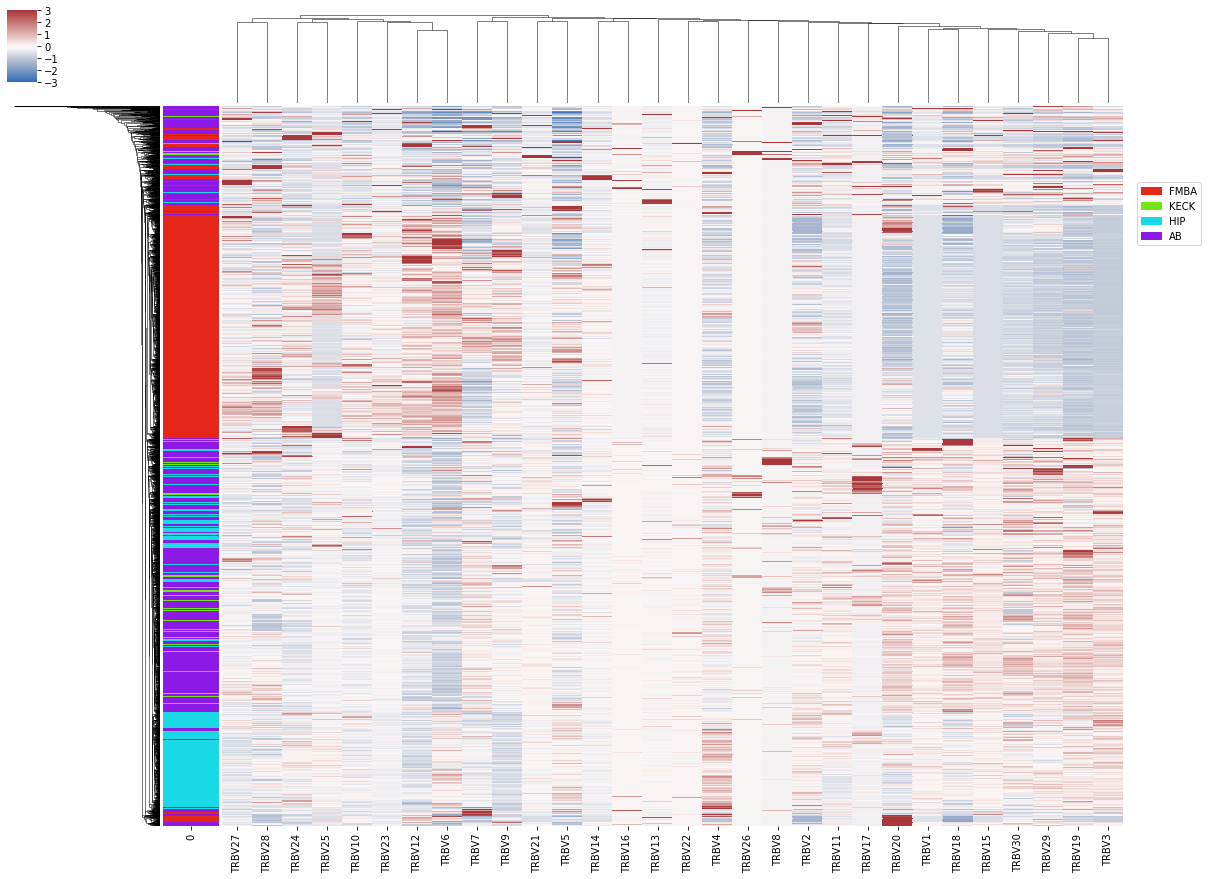

In [234]:
legend_TN = [mpatches.Patch(color=lut[l], label=l) for l in set(labels)]

g=sns.clustermap(v_usage_to_plot,figsize=(20, 15),row_colors=row_colors,cmap="vlag",vmin=-3, vmax=3,
              yticklabels=False,z_score=1)

g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)



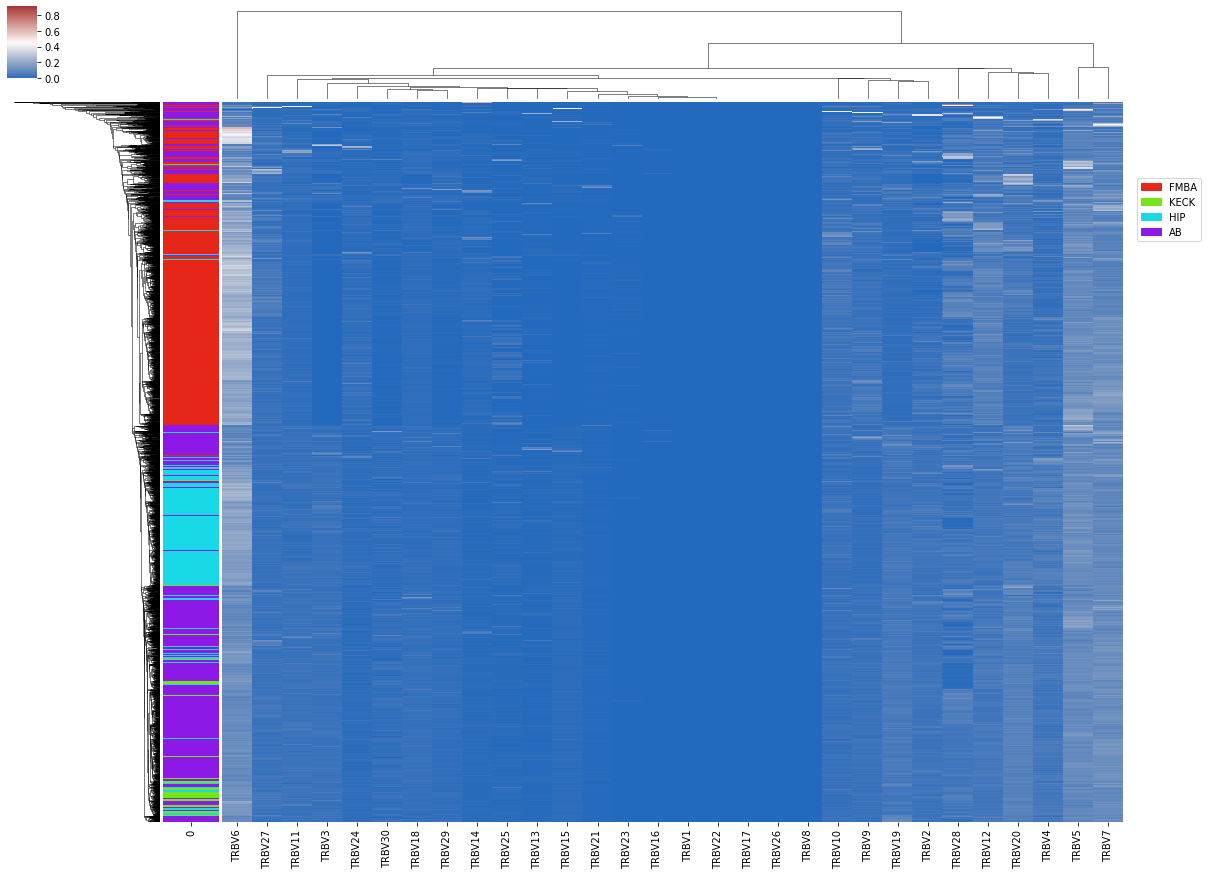

In [231]:
legend_TN = [mpatches.Patch(color=lut[l], label=l) for l in set(labels)]

g=sns.clustermap(v_usage_to_plot,figsize=(20, 15),row_colors=row_colors,cmap="vlag",
              yticklabels=False)

g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)



## Estimate size factors

In [37]:
#hip_keck_colapse["COVID-19-status"]="healthy"
#fmba_colapse=fmba_colapse.drop(columns=["sample_id"])
#fmba_colapse=fmba_colapse.rename(columns={"CSP": "sample_id"})

all_samples_V_usage=pd.concat([hip_keck_colapse,adaptive_colapse,fmba_colapse,VIP_colapse],sort=True)

all_samples_V_usage=all_samples_V_usage.fillna(0)


In [38]:
all_samples_V_usage.tail()

,COVID-19-status,Dataset,TRBV1,TRBV10,TRBV11,TRBV12,TRBV13,TRBV14,TRBV15,TRBV16,...,TRBV3,TRBV30,TRBV4,TRBV5,TRBV6,TRBV7,TRBV8,TRBV9,passed_clones,sample_id
5,VIP,VIP,0.0,0.027285,0.068887,0.060840,0.001395,0.033001,0.000195,0.0,...,0.001280,0.003372,0.038629,0.157773,0.109442,0.213638,0.0,0.037098,0.0,/home/taumata/COV_VIP/VIP-ID770500770101-TRAB-...
6,VIP,VIP,0.0,0.035755,0.015790,0.083587,0.001580,0.040857,0.000107,0.0,...,0.000499,0.003989,0.027004,0.107438,0.313279,0.101481,0.0,0.025869,0.0,/home/taumata/COV_VIP/VIP-ID770500980102-TRAB-...
7,VIP,VIP,0.0,0.043327,0.017895,0.108835,0.010733,0.006579,0.000714,0.0,...,0.019925,0.009605,0.077707,0.180940,0.095113,0.157538,0.0,0.065226,0.0,/home/taumata/COV_VIP/VIP82-new-mix-TRAB-DNA_S...
8,VIP,VIP,0.0,0.048587,0.014278,0.079356,0.005428,0.012174,0.000149,0.0,...,0.000413,0.004626,0.059819,0.142465,0.213006,0.162112,0.0,0.047973,0.0,/home/taumata/COV_VIP/VIP-ID770500820101-TRAB-...
9,VIP,VIP,0.0,0.036137,0.014741,0.078899,0.002623,0.013741,0.000091,0.0,...,0.000376,0.004076,0.059105,0.098458,0.286889,0.119783,0.0,0.048342,0.0,/home/taumata/COV_VIP/VIP-ID770500970102-TRAB-...


In [39]:
trbv_frequency={}
for dataset in set(all_samples_V_usage["Dataset"]):
    trbv_frequency[dataset]={}
    for trbv in set([xT.split("-")[0] for xT in all_samples_V_usage.columns if xT.startswith("TRBV")]):
         trbv_frequency[dataset][trbv]=all_samples_V_usage.loc[all_samples_V_usage["Dataset"]==dataset, trbv].median()


In [40]:
pd.DataFrame(trbv_frequency).columns

Index(['HIP', 'KECK', 'FMBA', 'VIP', 'AB'], dtype='object')

In [41]:
trbv_frequency_df=pd.DataFrame(trbv_frequency) #HERE 02.04
trbv_frequency_df


,HIP,KECK,FMBA,VIP,AB
TRBV19,0.047876,0.044970,0.018159,0.016871,0.053414
TRBV25,0.010625,0.009120,0.002014,0.032613,0.007149
TRBV3,0.031912,0.039421,0.000627,0.000519,0.030280
TRBV6,0.183328,0.143894,0.231559,0.189729,0.114867
TRBV4,0.067625,0.049319,0.032964,0.045616,0.045153
TRBV1,0.000384,0.000564,0.000000,0.000000,0.000429
TRBV13,0.006318,0.007466,0.002998,0.004205,0.005177
TRBV18,0.019297,0.022791,0.014527,0.015792,0.025347
TRBV7,0.106263,0.104751,0.109561,0.132860,0.121819
TRBV22,0.000001,0.000002,0.000000,0.000000,0.000002


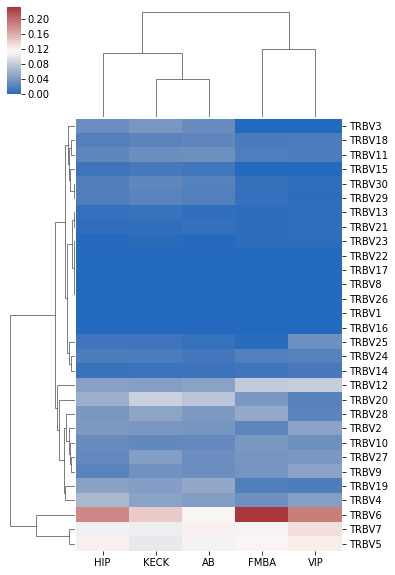

In [42]:
#pd.DataFrame(trbv_frequency)
sns.clustermap(trbv_frequency_df,
               figsize=(6, 10),cmap="vlag")


In [44]:
row[["AB","HIP","FMBA","KECK"]].median()

0.01070537421442971

In [45]:
size_factor=dict([(dataset_name,{}) for dataset_name in trbv_frequency_df.columns])
for index, row in trbv_frequency_df.iterrows():
    if sum(row==0)>0: #ar least in one dateset TRBV is 0
        for dataset_name in trbv_frequency_df.columns:
            size_factor[dataset_name][row.name]=0
    else:
        median_freq=row[["AB","HIP","FMBA","KECK"]].median()
        for dataset_name in trbv_frequency_df.columns:
            size_factor[dataset_name][row.name]=median_freq/row[dataset_name]


In [46]:
size_factor

{'HIP': {'TRBV19': 0.9696526264929384,
  'TRBV25': 0.7655746756640096,
  'TRBV3': 0.9744259152962254,
  'TRBV6': 0.8924514689607587,
  'TRBV4': 0.6984942475076265,
  'TRBV1': 0,
  'TRBV13': 0.9097282888192151,
  'TRBV18': 1.0905328905600231,
  'TRBV7': 1.0155222141374813,
  'TRBV22': 0,
  'TRBV2': 0.9249154489924494,
  'TRBV5': 0.9205200808171231,
  'TRBV24': 0.9770598017509776,
  'TRBV21': 1.0031305245028912,
  'TRBV30': 1.0496089121290457,
  'TRBV28': 1.1768387951675356,
  'TRBV10': 0.954173134485812,
  'TRBV8': 0,
  'TRBV26': 0,
  'TRBV14': 1.0825038173730288,
  'TRBV27': 1.274321390760138,
  'TRBV29': 1.048939780350968,
  'TRBV12': 1.0175151529743258,
  'TRBV23': 1.3579301130472188,
  'TRBV9': 1.5157188423376775,
  'TRBV16': 0,
  'TRBV20': 1.1561166801736056,
  'TRBV11': 1.1344797305124823,
  'TRBV17': 0,
  'TRBV15': 1.0802471923374612},
 'KECK': {'TRBV19': 1.0323083187394015,
  'TRBV25': 0.8919022331844108,
  'TRBV3': 0.7888264656056776,
  'TRBV6': 1.137021440286665,
  'TRBV4': 0.

## Adjust frequencies in samples

In [160]:
import numpy as np

In [161]:
size_factor

{'FMBA': {'TRBV6': 0.7194949636600677,
  'TRBV22': 0,
  'TRBV7': 1.077321885572708,
  'TRBV28': 0.8113724539397864,
  'TRBV23': 0.6159107588596424,
  'TRBV20': 1.3969751841327989,
  'TRBV5': 0.9690618969692342,
  'TRBV13': 1.6602023936078456,
  'TRBV11': 1.7333964675241063,
  'TRBV3': 29.515127084044963,
  'TRBV16': 0,
  'TRBV24': 0.9533551064754603,
  'TRBV2': 1.9914478581312913,
  'TRBV26': 0,
  'TRBV25': 6.011941671220078,
  'TRBV4': 1.5285401403086532,
  'TRBV8': 0,
  'TRBV17': 0,
  'TRBV1': 0,
  'TRBV29': 2.7000130562718536,
  'TRBV19': 2.604044337326082,
  'TRBV10': 0.7003128706868438,
  'TRBV30': 3.162052915232371,
  'TRBV9': 0.9075244623743002,
  'TRBV12': 0.5810698019844063,
  'TRBV21': 1.4262883704675355,
  'TRBV18': 1.5485884701704058,
  'TRBV27': 0.8865565153644409,
  'TRBV14': 0.9038253425028105,
  'TRBV15': 89.65219936843481},
 'KECK': {'TRBV6': 1.137021440286665,
  'TRBV22': 0,
  'TRBV7': 1.0072147089061976,
  'TRBV28': 0.9204453316807318,
  'TRBV23': 0.9721433234019217,

In [162]:
np.mean(list(size_factor["FMBA"].values()))

5.135220779175416

In [48]:
def adjust_frequencies_batch(input_file_path, out_file_path, size_factor):
    clonoset=pd.read_csv(input_file_path,
                    sep="\t")
    clonoset["v"]=[xT.split("-")[0] for xT in clonoset["v"]]
    for trbv in size_factor:
        if size_factor[trbv]==0:
            clonoset=clonoset.loc[clonoset["v"]!=trbv,:]
        else:
            clonoset.loc[clonoset["v"]==trbv,"freq"]=clonoset.loc[clonoset["v"]==trbv,"freq"]*size_factor[trbv]
    clonoset["freq"]=clonoset["freq"]/sum(clonoset["freq"])    # make freq sum to 1
    clonoset.to_csv(out_file_path, sep="\t", index=False)
    return "good"


In [244]:
#ADAPTIVE

In [245]:
minimum_number_of_TCRs=2000

adaptive_stats=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/AB_corr_functional/ncfilter.summary.txt",
                           sep="\t",header=0)

normal_size_sammples=list(adaptive_stats.loc[adaptive_stats["passed_clones"]>minimum_number_of_TCRs,"sample_id"])

input_folder="/home/taumata/COV_AdaptiveBiotech_v2/AB_corr_functional"

output_folder="/home/taumata/COV_AdaptiveBiotech_v2/AB_func_batch_adjusted_frequencies_withReseq_v2"

#---make output folder
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass


#--define function wrapper for takeTopAA
def adjust_frequencies_wrap(sample_id, input_folder=input_folder, output_folder=output_folder,
                            size_factor=size_factor["AB"]):
    result=adjust_frequencies_batch(str(input_folder) +"/"+str(sample_id),
                             str(output_folder)+"/"+str(sample_id),
                             size_factor)
    return (sample_id, result)

#--run multiprocess                                   
print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(adjust_frequencies_wrap, normal_size_sammples)
pool.close()
good_or_bad=dict(results)
print("DONE")

#--make metadata file
with open(str(output_folder)+"/metadata.txt","w") as meta_file:
    for sample_id in good_or_bad:
        if good_or_bad[sample_id]=="good":
            meta_file.write(str(sample_id)+"\n")
        else:
            print(good_or_bad[sample_id])
        
        

/home/taumata/COV_AdaptiveBiotech_v2/AB_func_batch_adjusted_frequencies_withReseq_v2
START
DONE


In [50]:
clonoset=pd.read_csv("/home/taumata/COV_VIP_adjusted/VIP-ID770500770101-TRAB-DNA_S1_L001.clonotypes.TRB.txt",
                     sep="\t")


In [51]:
for trbv in size_factor["VIP"]:
    print(trbv)
    print(trbv_frequency_df.loc[trbv,"VIP"])
    print(clonoset.loc[clonoset["v"]==trbv,"freq"].sum())
    

TRBV19
0.0168706339795636
0.036186024060095974
TRBV25
0.03261272038776861
0.0073568369099247
TRBV3
0.0005193774133286564
0.06975887790610966
TRBV6
0.18972861231321037
0.08593807018096311
TRBV4
0.04561602479666143
0.03642440803871938
TRBV1
0.0
0.0
TRBV13
0.0042053549812275555
0.001736266192222744
TRBV18
0.015791916813898303
0.011729394375039991
TRBV7
0.13285978834676646
0.1580073133023276
TRBV22
0.0
0.0
TRBV2
0.04847795545100972
0.028371197749158972
TRBV5
0.12417484953298151
0.1301183104684474
TRBV24
0.020368264940692028
0.038595858114897276
TRBV21
0.004643518017796209
0.0031170683471829644
TRBV30
0.004419715783076693
0.013784761932762688
TRBV28
0.023195840806198763
0.04501250277868217
TRBV10
0.03341635566935404
0.02176959566037439
TRBV8
0.0
0.0
TRBV26
0.0
0.0
TRBV14
0.014255170540077987
0.01830531797541614
TRBV27
0.03981081726987274
0.036015431914044625
TRBV29
0.002919129309770565
0.015932958178534466
TRBV12
0.08147156639255429
0.03245513704802843
TRBV23
0.00337350589622559
0.000838208

In [248]:
#HIP

In [249]:
hip_stats=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/hip_corr_func/ncfilter.summary.txt",
                           sep="\t",header=0)
hip_stats.loc[hip_stats["sample_id"].str.startswith("HIP")]

,sample_id,age,race,sex,cmv,hla,..filter..,passed_clones,total_clones,passed_count,total_count,passed_freq,total_freq
0,HIP00110,55.0,NaN,male,-,"HLA-A*03,HLA-A*24,HLA-B*07",corr:2:0.05:all,99455,124200,3215360,4024856,0.798876,1.0
1,HIP00169,41.0,NaN,male,-,"HLA-A*01,HLA-A*02,HLA-B*27,HLA-B*37",corr:2:0.05:all,94544,112862,1120176,1326663,0.844356,1.0
2,HIP00594,21.0,"caucasian,non-hispanic or latino",male,+,"HLA-A*02,HLA-A*32,HLA-B*07,HLA-B*61",corr:2:0.05:all,155820,192216,2355571,2895778,0.813450,1.0
3,HIP00602,45.0,NaN,female,-,"HLA-A*02,HLA-A*11,HLA-B*35,HLA-B*51",corr:2:0.05:all,187302,235730,7464299,9504930,0.785308,1.0
4,HIP00614,27.0,"caucasian,non-hispanic or latino",male,-,"HLA-A*03,HLA-A*29,HLA-B*07",corr:2:0.05:all,98351,119478,1572268,1919032,0.819303,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,HIP17887,NaN,NaN,NaN,NaN,"HLA-A*02,HLA-A*29,HLA-B*07,HLA-B*44",corr:2:0.05:all,190398,226116,2008870,2381197,0.843639,1.0
662,HIP19048,57.0,NaN,female,-,"HLA-A*01,HLA-A*02,HLA-B*51,HLA-B*57",corr:2:0.05:all,50692,65188,4774950,6038058,0.790809,1.0
663,HIP19089,NaN,NaN,NaN,NaN,"HLA-A*01,HLA-A*80,HLA-B*13,HLA-B*44",corr:2:0.05:all,62136,71760,734376,839205,0.875085,1.0
664,HIP19716,NaN,NaN,NaN,NaN,"HLA-A*01,HLA-B*08",corr:2:0.05:all,96542,121741,3760321,4806917,0.782273,1.0


In [204]:
sum(hip_stats["passed_clones"]>minimum_number_of_TCRs)/len(hip_stats["passed_clones"])

0.9987277353689568

In [250]:
minimum_number_of_TCRs=2000

hip_stats=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/hip_corr_func/ncfilter.summary.txt",
                           sep="\t",header=0)
normal_size_sammples=list(hip_stats.loc[(hip_stats["passed_clones"]>minimum_number_of_TCRs)&
                                        (hip_stats["sample_id"].str.startswith("HIP")),"sample_id"])

normal_size_sammples=[str(xT)+".txt" for xT in normal_size_sammples] #add .txt to the end of files to be like Adaptive

input_folder="/home/taumata/COV_AdaptiveBiotech_v2/hip_corr_func"
output_folder="/home/taumata/COV_AdaptiveBiotech_v2/HIP_func_batch_adjusted_frequencies_withReseq_v2"
#---make output folder
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass


#--define function wrapper for takeTopAA
def adjust_frequencies_wrap(sample_id, input_folder=input_folder, output_folder=output_folder,
                            size_factor=size_factor["HIP"]):
    result=adjust_frequencies_batch(str(input_folder) +"/"+str(sample_id),
                             str(output_folder)+"/"+str(sample_id),
                             size_factor)
    return (sample_id, result)

#--run multiprocess                                   
print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(adjust_frequencies_wrap, normal_size_sammples)
pool.close()
good_or_bad=dict(results)
print("DONE")

#--make metadata file
with open(str(output_folder)+"/metadata.txt","w") as meta_file:
    for sample_id in good_or_bad:
        if good_or_bad[sample_id]=="good":
            meta_file.write(str(sample_id)+"\n")
        else:
            print(good_or_bad[sample_id])
        
        


/home/taumata/COV_AdaptiveBiotech_v2/HIP_func_batch_adjusted_frequencies_withReseq_v2
START
DONE


In [251]:
minimum_number_of_TCRs=2000

hip_stats=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/hip_corr_func/ncfilter.summary.txt",
                           sep="\t",header=0)
normal_size_sammples=list(hip_stats.loc[(hip_stats["passed_clones"]>minimum_number_of_TCRs)&
                                        (hip_stats["sample_id"].str.startswith("Keck")),"sample_id"])

normal_size_sammples=[str(xT)+".txt" for xT in normal_size_sammples] #add .txt to the end of files to be like Adaptive

input_folder="/home/taumata/COV_AdaptiveBiotech_v2/hip_corr_func"
output_folder="/home/taumata/COV_AdaptiveBiotech_v2/KECK_func_batch_adjusted_frequencies_withReseq_v2"
#---make output folder
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass


#--define function wrapper for takeTopAA
def adjust_frequencies_wrap(sample_id, input_folder=input_folder, output_folder=output_folder,
                            size_factor=size_factor["KECK"]):
    result=adjust_frequencies_batch(str(input_folder) +"/"+str(sample_id),
                             str(output_folder)+"/"+str(sample_id),
                             size_factor)
    return (sample_id, result)

#--run multiprocess                                   
print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(adjust_frequencies_wrap, normal_size_sammples)
pool.close()
good_or_bad=dict(results)
print("DONE")

#--make metadata file
with open(str(output_folder)+"/metadata.txt","w") as meta_file:
    for sample_id in good_or_bad:
        if good_or_bad[sample_id]=="good":
            meta_file.write(str(sample_id)+"\n")
        else:
            print(good_or_bad[sample_id])
        



/home/taumata/COV_AdaptiveBiotech_v2/KECK_func_batch_adjusted_frequencies_withReseq_v2
START
DONE


In [ ]:
#FMBA

In [252]:
minimum_number_of_TCRs=2000

fmba_stats=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_Reseq_func/metadata.txt",
                           sep="\t",header=None)
normal_size_sammples=list(fmba_stats[0])

input_folder="/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_Reseq_func"
output_folder="/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_func_batch_adjusted_frequencies_withReseq_v2"


#---make output folder
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass


#--define function wrapper for takeTopAA
def adjust_frequencies_wrap(sample_id, input_folder=input_folder, output_folder=output_folder,
                            size_factor=size_factor["FMBA"]):
    result=adjust_frequencies_batch(str(input_folder) +"/"+str(sample_id),
                             str(output_folder)+"/"+str(sample_id),
                             size_factor)
    return (sample_id, result)

#--run multiprocess                                   
print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(adjust_frequencies_wrap, normal_size_sammples)
pool.close()
good_or_bad=dict(results)
print("DONE")

#--make metadata file
with open(str(output_folder)+"/metadata.txt","w") as meta_file:
    for sample_id in good_or_bad:
        if good_or_bad[sample_id]=="good":
            meta_file.write(str(sample_id)+"\n")
        else:
            print(good_or_bad[sample_id])
        
        



/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_func_batch_adjusted_frequencies_withReseq_v2
START
DONE


In [253]:
print("OK")

OK


In [49]:
minimum_number_of_TCRs=2000


normal_size_sammples=[sample_name for sample_name in os.listdir("/home/taumata/COV_VIP")]
input_folder="/home/taumata/COV_VIP"
output_folder="/home/taumata/COV_VIP_adjusted"
#---make output folder
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass


#--define function wrapper for takeTopAA
def adjust_frequencies_wrap(sample_id, input_folder=input_folder, output_folder=output_folder,
                            size_factor=size_factor["VIP"]):
    result=adjust_frequencies_batch(str(input_folder) +"/"+str(sample_id),
                             str(output_folder)+"/"+str(sample_id),
                             size_factor)
    return (sample_id, result)

#--run multiprocess                                   
print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(adjust_frequencies_wrap, normal_size_sammples)
pool.close()
good_or_bad=dict(results)
print("DONE")

#--make metadata file
with open(str(output_folder)+"/metadata.txt","w") as meta_file:
    for sample_id in good_or_bad:
        if good_or_bad[sample_id]=="good":
            meta_file.write(str(sample_id)+"\n")
        else:
            print(good_or_bad[sample_id])
        
        



/home/taumata/COV_VIP_adjusted
START
DONE


## Calculate new V-usage

In [ ]:
#ADAPTIVE

In [260]:
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/AB_func_batch_adjusted_frequencies_withReseq_v2/metadata.txt",
                    sep="\t")
folder="/home/taumata/COV_AdaptiveBiotech_v2/AB_func_batch_adjusted_frequencies_withReseq_v2"



In [261]:
v_usage={}
all_v=set()
for index, row in metadata.iterrows():
    clonoset=pd.read_csv(str(folder)+"/"+str(row[0]), sep="\t")
    sample_v_usage=clonoset.groupby(['v']).sum()
    v_usage[row[0]]=dict(sample_v_usage["freq"])
    all_v=all_v|set(sample_v_usage.index)
    

In [262]:
all_v=list(all_v)
with open("/home/taumata/tcr-association/random_forest_v2/V_usage/AB_corr_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv", "w") as out_file:
    out_file.write("sample_id\t"+"\t".join(all_v))
    for sample_name in v_usage:
        out_file.write("\n"+str(sample_name))
        for v_segment in all_v:
            if v_segment in v_usage[sample_name]:
                out_file.write("\t"+str(v_usage[sample_name][v_segment]))
            else:
                out_file.write("\t0")

In [263]:
#HIP
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/HIP_func_batch_adjusted_frequencies_withReseq_v2/metadata.txt",
                    sep="\t")
folder="/home/taumata/COV_AdaptiveBiotech_v2/HIP_func_batch_adjusted_frequencies_withReseq_v2"

v_usage={}
all_v=set()
for index, row in metadata.iterrows():
    clonoset=pd.read_csv(str(folder)+"/"+str(row[0]), sep="\t")
    sample_v_usage=clonoset.groupby(['v']).sum()
    v_usage[row[0]]=dict(sample_v_usage["freq"])
    all_v=all_v|set(sample_v_usage.index)
    
all_v=list(all_v)
with open("/home/taumata/tcr-association/random_forest_v2/V_usage/HIP_corr_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv", "w") as out_file:
    out_file.write("sample_id\t"+"\t".join(all_v))
    for sample_name in v_usage:
        out_file.write("\n"+str(sample_name))
        for v_segment in all_v:
            if v_segment in v_usage[sample_name]:
                out_file.write("\t"+str(v_usage[sample_name][v_segment]))
            else:
                out_file.write("\t0")
                

In [264]:
#KECK
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/KECK_func_batch_adjusted_frequencies_withReseq_v2/metadata.txt",
                    sep="\t")
folder="/home/taumata/COV_AdaptiveBiotech_v2/KECK_func_batch_adjusted_frequencies_withReseq_v2"

v_usage={}
all_v=set()
for index, row in metadata.iterrows():
    clonoset=pd.read_csv(str(folder)+"/"+str(row[0]), sep="\t")
    sample_v_usage=clonoset.groupby(['v']).sum()
    v_usage[row[0]]=dict(sample_v_usage["freq"])
    all_v=all_v|set(sample_v_usage.index)
    
all_v=list(all_v)
with open("/home/taumata/tcr-association/random_forest_v2/V_usage/KECK_corr_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv", "w") as out_file:
    out_file.write("sample_id\t"+"\t".join(all_v))
    for sample_name in v_usage:
        out_file.write("\n"+str(sample_name))
        for v_segment in all_v:
            if v_segment in v_usage[sample_name]:
                out_file.write("\t"+str(v_usage[sample_name][v_segment]))
            else:
                out_file.write("\t0")
                

In [265]:
#FMBA
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_func_batch_adjusted_frequencies_withReseq_v2/metadata.txt",
                    sep="\t")
folder="/home/taumata/COV_AdaptiveBiotech_v2/FMBA_TRB_func_batch_adjusted_frequencies_withReseq_v2"

v_usage={}
all_v=set()
for index, row in metadata.iterrows():
    clonoset=pd.read_csv(str(folder)+"/"+str(row[0]), sep="\t")
    sample_v_usage=clonoset.groupby(['v']).sum()
    v_usage[row[0]]=dict(sample_v_usage["freq"])
    all_v=all_v|set(sample_v_usage.index)
    
all_v=list(all_v)
with open("/home/taumata/tcr-association/random_forest_v2/V_usage/FMBA_TRB_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv", "w") as out_file:
    out_file.write("sample_id\t"+"\t".join(all_v))
    for sample_name in v_usage:
        out_file.write("\n"+str(sample_name))
        for v_segment in all_v:
            if v_segment in v_usage[sample_name]:
                out_file.write("\t"+str(v_usage[sample_name][v_segment]))
            else:
                out_file.write("\t0")
                

In [266]:
print("OK")

OK


# PLOT Adjusted frequencies

In [280]:
AB_vusage_adj=pd.read_csv("/home/taumata/tcr-association/random_forest_v2/V_usage/AB_corr_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv",
                          sep="\t")
HIP_vusage_adj=pd.read_csv("/home/taumata/tcr-association/random_forest_v2/V_usage/HIP_corr_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv",
                          sep="\t")
KECK_vusage_adj=pd.read_csv("/home/taumata/tcr-association/random_forest_v2/V_usage/KECK_corr_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv",
                          sep="\t")
FMBA_vusage_adj=pd.read_csv("/home/taumata/tcr-association/random_forest_v2/V_usage/FMBA_TRB_func_Vusage_batch_adjusted_frequencies_withReseq_v2.tsv",
                          sep="\t")



In [281]:
HIP_vusage_adj["Dataset"]="HIP"
KECK_vusage_adj["Dataset"]="KECK" 
AB_vusage_adj["Dataset"]="AB"
FMBA_vusage_adj["Dataset"]="FMBA"


In [282]:
all_samples_V_usage_adj=pd.concat([AB_vusage_adj,HIP_vusage_adj,KECK_vusage_adj,FMBA_vusage_adj],sort=True)
all_samples_V_usage_adj=all_samples_V_usage_adj.fillna(0)


In [283]:
v_usage_to_plot=all_samples_V_usage_adj.drop(columns=["sample_id",
                                                 "Dataset"])


labels=list(all_samples_V_usage_adj["Dataset"])
sample_id=list(all_samples_V_usage_adj["sample_id"])


v_usage_to_plot.index=sample_id


lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(labels)
row_colors[0]=list(map(lambda x: (lut[x]), row_colors[0]))
row_colors.index=sample_id


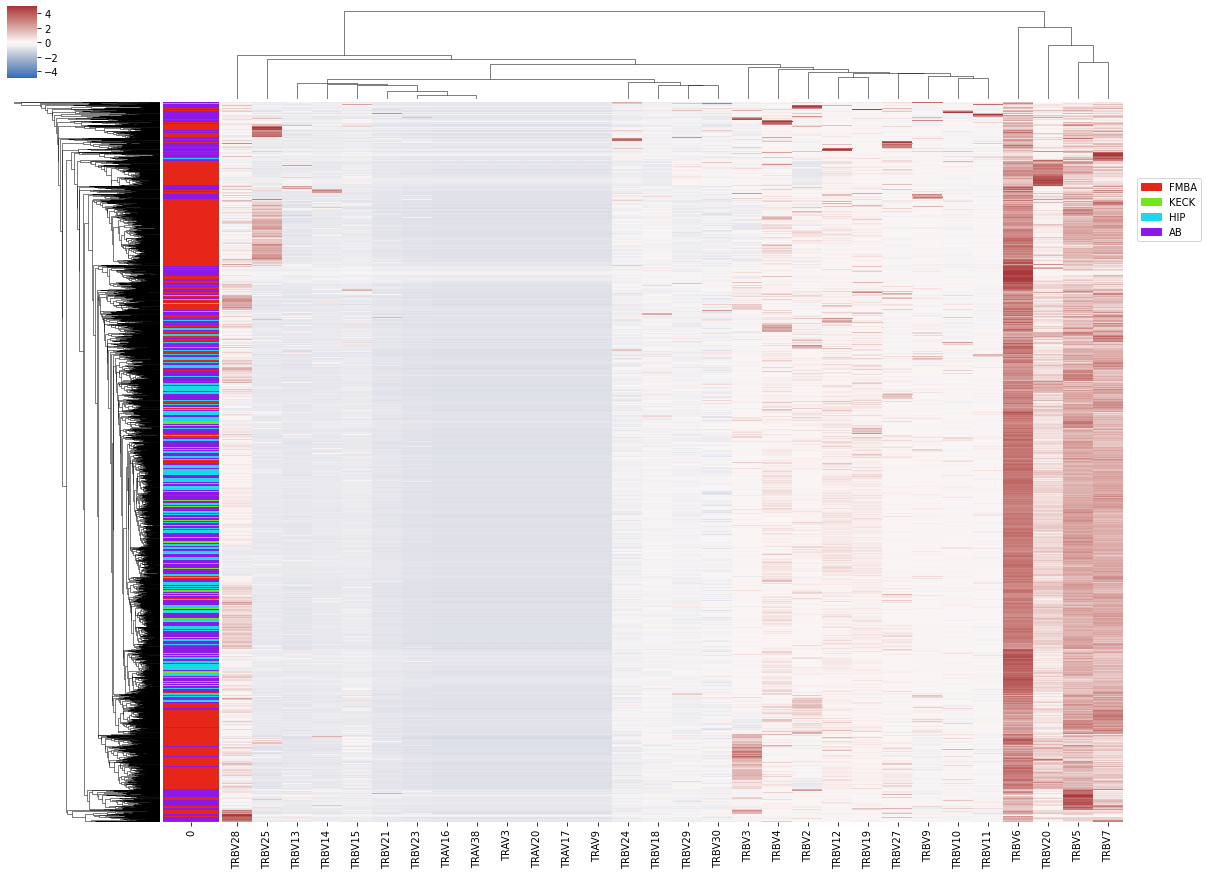

In [284]:
legend_TN = [mpatches.Patch(color=lut[l], label=l) for l in set(labels)]

g=sns.clustermap(v_usage_to_plot,figsize=(20, 15),row_colors=row_colors,cmap="vlag", vmin=-5, vmax=5,
              yticklabels=False,z_score=0)

g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)


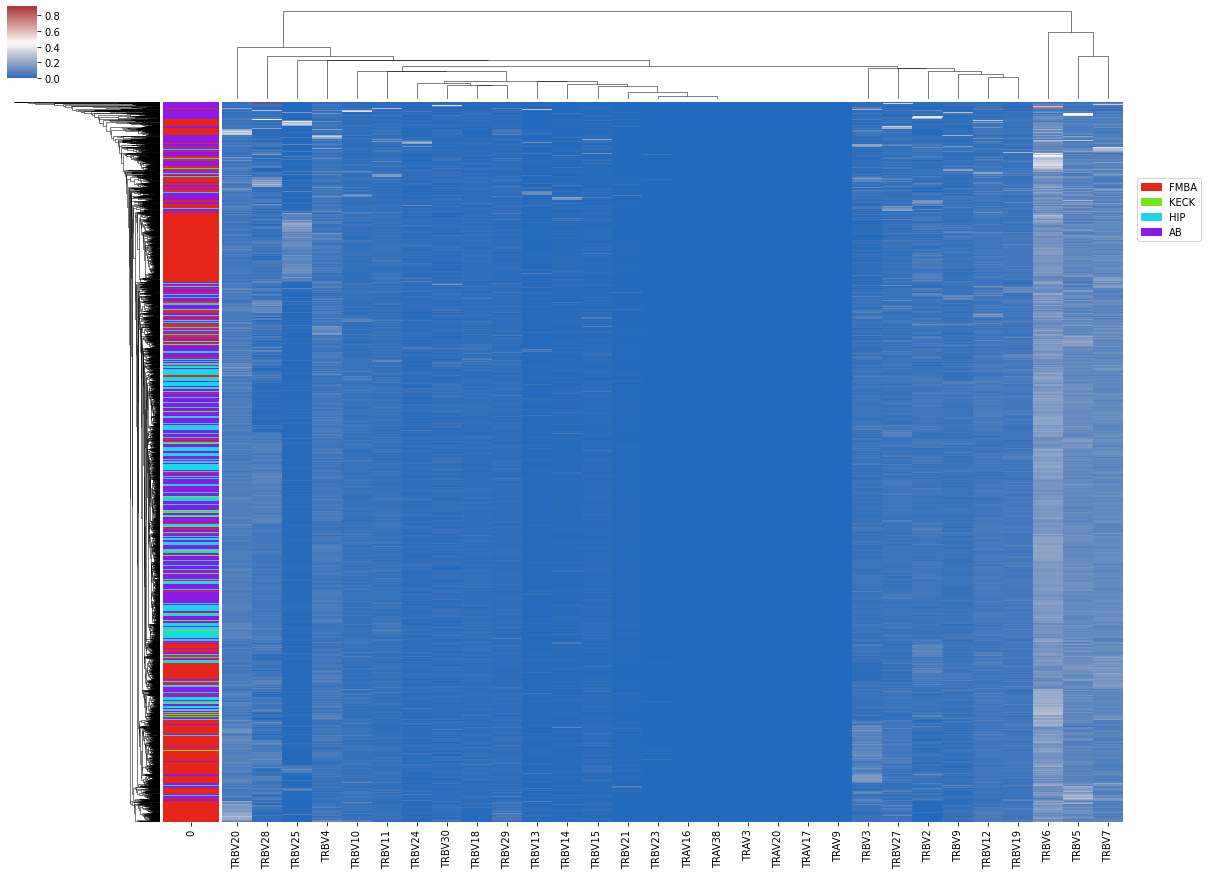

In [279]:
legend_TN = [mpatches.Patch(color=lut[l], label=l) for l in set(labels)]

g=sns.clustermap(v_usage_to_plot,figsize=(20, 15),row_colors=row_colors,cmap="vlag",
              yticklabels=False)

g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)



In [274]:
v_usage_to_plot.max()

TRAV16    0.000004
TRAV17    0.000002
TRAV20    0.000002
TRAV3     0.000003
TRAV38    0.000003
TRAV9     0.000001
TRBV10    0.867448
TRBV11    0.727058
TRBV12    0.425940
TRBV13    0.711360
TRBV14    0.613387
TRBV15    0.452750
TRBV18    0.184582
TRBV19    0.420959
TRBV2     0.508145
TRBV20    0.425893
TRBV21    0.146993
TRBV23    0.098024
TRBV24    0.283624
TRBV25    0.778153
TRBV27    0.667620
TRBV28    0.909863
TRBV29    0.446109
TRBV3     0.641942
TRBV30    0.522735
TRBV4     0.838139
TRBV5     0.576577
TRBV6     0.818204
TRBV7     0.750659
TRBV9     0.475466
dtype: float64

In [221]:
print("OK")

OK


In [275]:
trbv_frequency={}
for dataset in set(all_samples_V_usage_adj["Dataset"]):
    trbv_frequency[dataset]={}
    for trbv in set([xT.split("-")[0] for xT in all_samples_V_usage_adj.columns if xT.startswith("TRBV")]):
         trbv_frequency[dataset][trbv]=all_samples_V_usage_adj.loc[all_samples_V_usage_adj["Dataset"]==dataset, trbv].median()

trbv_frequency_df=pd.DataFrame(trbv_frequency) #HERE 02.04
trbv_frequency_df

,FMBA,KECK,HIP,AB
TRBV6,0.146934,0.167675,0.166339,0.159493
TRBV7,0.097176,0.110449,0.109616,0.104711
TRBV28,0.042543,0.047445,0.047321,0.045078
TRBV23,0.001654,0.001851,0.001843,0.001753
TRBV20,0.061947,0.069473,0.068330,0.065730
TRBV5,0.099571,0.116423,0.114086,0.109656
TRBV13,0.005230,0.005853,0.005792,0.005596
TRBV11,0.025987,0.029690,0.029503,0.028208
TRBV3,0.028381,0.032270,0.031674,0.030326
TRBV24,0.014823,0.016799,0.016565,0.015914


## 3) Read COVID-associated clonotypes (found by Dasha)

In [136]:
clones=pd.read_csv("fmba_dasha_new_features.tsv",sep="\t")
COVID_associated_clones=clones["cdr3aa"]


## Find fraction of clonotypes with one or zero mismatches 

In [137]:
def hamming_distance_bound1(string1, string2):
    if len(string1) != len(string2):
        return 2
    hamm_dist = 0
    for n in range(len(string1)):
        if string1[n] != string2[n]:
            hamm_dist += 1
            if hamm_dist>1:
                return hamm_dist
    return hamm_dist


def get_clonotypes_frequences_hamming1(sample_name, path_to_folder_with_sample, clones_for_analyse , treshold=100):
    local_clones_in_samples=dict([(xT,0) for xT in clones_for_analyse]) #initialize by all zeroes
    clonoset=pd.read_csv(str(path_to_folder_with_sample)+"/"+str(sample_name),
                         sep="\t")
    total_counts=0
    for index,row in clonoset.iterrows():
        total_counts+=float(row["count"])
        #zero or one mismatch  in amino acid CDR3 sequence
        for clone_of_interest in local_clones_in_samples:
            if hamming_distance_bound1(clone_of_interest, row["cdr3aa"])<=1: #!!!FUNCTION FOR UPPER BOUNDED hamming!!!
                local_clones_in_samples[clone_of_interest]+=float(row["freq"]) #clone[1] is fraction
    if total_counts<treshold: #we will remember names of too small samples
        return (sample_name,"too_small")
    return (sample_name, local_clones_in_samples)


In [280]:
#ADAPTIVE

In [138]:
treshold=100 #remove samples smaller than this treshold
folder_with_samples="/home/taumata/COV_AdaptiveBiotech_v2/AB_corr_functional_batch_adjusted_frequencies" #must contain metadata.txt
output_file_name="/home/taumata/tcr-association/random_forest_v2/V_usage/AB_corr_functional_batch_adjusted_frequencies_ALL_cac_hamming1.tsv"

#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------
#----find fraction of clonotypes of interest in samples
def get_clonotypes_frequences_hamming1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=COVID_associated_clones,
                                                   treshold=treshold):
    return get_clonotypes_frequences_hamming1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse,
                                                  treshold=treshold)



print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_clonotypes_frequences_hamming1_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#----save results
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(COVID_associated_clones))
    for sample_name in clones_in_samples:
        if clones_in_samples[sample_name]=="too_small":
            bad_files+=1
            continue
        else:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in COVID_associated_clones]))
            
print(bad_files)




START


Process ForkPoolWorker-147:
Process ForkPoolWorker-150:
Process ForkPoolWorker-145:
Process ForkPoolWorker-137:
Process ForkPoolWorker-143:
Process ForkPoolWorker-149:
Process ForkPoolWorker-138:
Process ForkPoolWorker-139:
Process ForkPoolWorker-130:
Process ForkPoolWorker-146:
Process ForkPoolWorker-127:
Process ForkPoolWorker-144:
Process ForkPoolWorker-140:
Process ForkPoolWorker-126:
Process ForkPoolWorker-128:
Process ForkPoolWorker-121:
Process ForkPoolWorker-129:
Process ForkPoolWorker-122:
Process ForkPoolWorker-135:
Process ForkPoolWorker-148:
Process ForkPoolWorker-132:
Process ForkPoolWorker-125:
Process ForkPoolWorker-124:
Process ForkPoolWorker-136:
Process ForkPoolWorker-131:
Process ForkPoolWorker-123:
Process ForkPoolWorker-142:
Process ForkPoolWorker-141:
Process ForkPoolWorker-134:
Process ForkPoolWorker-133:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _b

  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", li

KeyboardInterrupt: 

  File "<ipython-input-138-a65652136b13>", line 18, in get_clonotypes_frequences_hamming1_wrapper
    treshold=treshold)
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-138-a65652136b13>", line 18, in get_clonotypes_frequences_hamming1_wrapper
    treshold=treshold)
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list

  File "<ipython-input-137-2dbc2dad9ac4>", line 22, in get_clonotypes_frequences_hamming1
    if hamming_distance_bound1(clone_of_interest, row["cdr3aa"])<=1: #!!!FUNCTION FOR UPPER BOUNDED hamming!!!
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 1068, in __getitem__
    result = self.index.get_value(self, key)
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-137-2dbc2dad9ac4>", line 22, in get_clonotypes_frequences_hamming1
    if hamming_distance_bound1(clone_of_interest, row["cdr3aa"])<=1: #!!!FUNCTION FOR UPPER BOUNDED hamming!!!
  File "/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/series.py",

  File "<ipython-input-137-2dbc2dad9ac4>", line 22, in get_clonotypes_frequences_hamming1
    if hamming_distance_bound1(clone_of_interest, row["cdr3aa"])<=1: #!!!FUNCTION FOR UPPER BOUNDED hamming!!!
  File "/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4728, in get_value
    k = self._convert_scalar_indexer(k, kind="getitem")
  File "<ipython-input-137-2dbc2dad9ac4>", line 22, in get_clonotypes_frequences_hamming1
    if hamming_distance_bound1(clone_of_interest, row["cdr3aa"])<=1: #!!!FUNCTION FOR UPPER BOUNDED hamming!!!
  File "/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 467, in dtype
    @property
  File "<ipython-input-137-2dbc2dad9ac4>", line 22, in get_clonotypes_frequences_hamming1
    if hamming_distance_bound1(clone_of_interest, row["cdr3aa"])<=1: #!!!FUNCTION FOR UPPER BOUNDED hamming!!!
KeyboardInterrupt
  File "<ipython-input-137-2dbc2dad9ac4>", line 22, in get_clonotypes_frequences_hamming1
  

KeyboardInterrupt
  File "/home/taumata/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4725, in get_value
    s = com.values_from_object(series)
  File "/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/generic.py", line 7, in _check
    @classmethod
  File "/home/taumata/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 723, in __len__
    def __len__(self):
KeyboardInterrupt
KeyboardInterrupt
  File "<ipython-input-138-a65652136b13>", line 18, in get_clonotypes_frequences_hamming1_wrapper
    treshold=treshold)
KeyboardInterrupt
KeyboardInterrupt
  File "pandas/_libs/lib.pyx", line 85, in pandas._libs.lib.values_from_object
KeyboardInterrupt
  File "<ipython-input-137-2dbc2dad9ac4>", line 18, in get_clonotypes_frequences_hamming1
    for index,row in clonoset.iterrows():
KeyboardInterrupt
  File "

In [ ]:
#HIP

In [ ]:
treshold=100 #remove samples smaller than this treshold
folder_with_samples="/home/taumata/COV_AdaptiveBiotech_v2/HIP_corr_functional_batch_adjusted_frequencies" #must contain metadata.txt
output_file_name="/home/taumata/tcr-association/random_forest_v2/V_usage/HIP_corr_functional_batch_adjusted_frequencies_ALL_cac_hamming1.tsv"

#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------
#----find fraction of clonotypes of interest in samples
def get_clonotypes_frequences_hamming1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=COVID_associated_clones,
                                                   treshold=treshold):
    return get_clonotypes_frequences_hamming1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse,
                                                  treshold=treshold)



print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_clonotypes_frequences_hamming1_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#----save results
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(COVID_associated_clones))
    for sample_name in clones_in_samples:
        if clones_in_samples[sample_name]=="too_small":
            bad_files+=1
            continue
        else:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in COVID_associated_clones]))
            
print(bad_files)





In [ ]:
treshold=100 #remove samples smaller than this treshold
folder_with_samples="/home/taumata/COV_AdaptiveBiotech_v2/KECK_corr_functional_batch_adjusted_frequencies" #must contain metadata.txt
output_file_name="/home/taumata/tcr-association/random_forest_v2/V_usage/KECK_corr_functional_batch_adjusted_frequencies_ALL_cac_hamming1.tsv"

#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------
#----find fraction of clonotypes of interest in samples
def get_clonotypes_frequences_hamming1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=COVID_associated_clones,
                                                   treshold=treshold):
    return get_clonotypes_frequences_hamming1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse,
                                                  treshold=treshold)



print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_clonotypes_frequences_hamming1_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#----save results
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(COVID_associated_clones))
    for sample_name in clones_in_samples:
        if clones_in_samples[sample_name]=="too_small":
            bad_files+=1
            continue
        else:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in COVID_associated_clones]))
            
print(bad_files)



In [ ]:
treshold=100 #remove samples smaller than this treshold
folder_with_samples="/home/taumata/COV_AdaptiveBiotech_v2/FMBA_new_corr_TRB_functional_batch_adjusted_frequencies" #must contain metadata.txt
output_file_name="/home/taumata/tcr-association/random_forest_v2/V_usage/FMBA_corr_functional_batch_adjusted_frequencies_ALL_cac_hamming1.tsv"

#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------
#----find fraction of clonotypes of interest in samples
def get_clonotypes_frequences_hamming1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=COVID_associated_clones,
                                                   treshold=treshold):
    return get_clonotypes_frequences_hamming1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse,
                                                  treshold=treshold)



print("START")    
pool = mp.Pool(30) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_clonotypes_frequences_hamming1_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#----save results
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(COVID_associated_clones))
    for sample_name in clones_in_samples:
        if clones_in_samples[sample_name]=="too_small":
            bad_files+=1
            continue
        else:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in COVID_associated_clones]))
            
print(bad_files)





In [ ]:
print("OK")

## Train randomForest

In [7]:
#RANDOMM FOREST with nested cross-validation
#HEAVILY BASED ON https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

def nested_cross_validation(X_to_fit, y_to_fit, 
                            max_features=[20, 50, 100],
                            max_depth=[5,7,9]):
    
    # configure the cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # enumerate splits
    outer_results = list()
    #class_weight = dict({"acute":784, "healthy":1108}) #weights reverse to sample sizes

    for train_ix, test_ix in cv_outer.split(X_to_fit, y_to_fit):
        # split data
        X_train, X_test = X_to_fit.iloc[train_ix], X_to_fit.iloc[test_ix]
        y_train, y_test = [y_to_fit[i] for i in train_ix],[y_to_fit[i] for i in test_ix]
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
        # define the model
        model = RandomForestClassifier(random_state=1,
                                       class_weight="balanced",
                                       n_estimators=500,
                                       n_jobs=40)
        # define search space
        space = dict()
        space['max_features'] = max_features
        space['max_depth']=max_depth
        # define search
        search = GridSearchCV(model, space, scoring='balanced_accuracy', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        y_train_hat = best_model.predict(X_train)
        # evaluate the model
        acc = balanced_accuracy_score(y_test, yhat)
        # store the result
        outer_results.append(acc)
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        print("balanced accuracy on train set " + str(balanced_accuracy_score(y_train, y_train_hat)))
        # output confusion matrix
        conf_mat = confusion_matrix(y_test, yhat)
        print(conf_mat)
    # summarize the estimated performance of the model
    print('Balanced accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

In [8]:
### 5.1.1) Test on different Datasets from Adaptive


In [9]:
#Read Adaptive metadata
metadata=pd.read_csv("AB_prediction/adaptive-metadata-edited.tsv",sep="\t")
metadata["sample_short_name"]=metadata["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names
adaptive_acute=set(metadata.loc[metadata["COVID-19-status"]=="acute","sample_short_name"])
metadata["COVID-19-status"].value_counts()

acute        1140
recovered     239
baseline       74
exposed        26
non-acute       4
Name: COVID-19-status, dtype: int64

In [10]:
#split Adaptive

In [11]:
#Read Adaptive and HIP data
AB_data=pd.read_csv("V_usage/AB_corr_functional_adjusted_frequencies_ALL_cac_hamming1.tsv",
                    sep="\t")
AB_data.index=[xT.split("_")[0] for xT in AB_data.index]

HIP_data=pd.read_csv("V_usage/HIP_corr_functional_adjusted_frequencies_ALL_cac_hamming1.tsv",
                    sep="\t")
HIP_data.index=[xT.split(".")[0] for xT in HIP_data.index]

common_columns_order=list(HIP_data.columns)

In [12]:
pd.crosstab(metadata["COVID-19-status"], metadata["Dataset"], dropna=False)


Dataset,COVID-19-Adaptive,COVID-19-Adaptive-MIRAMatched,COVID-19-BWNW,COVID-19-DLS,COVID-19-HUniv12Oct,COVID-19-IRST/AUSL,COVID-19-ISB,COVID-19-NIH/NIAID
COVID-19-status,,,,,,,,
acute,37,3,0,433,177,64,69,357
baseline,0,0,0,0,0,0,74,0
exposed,23,3,0,0,0,0,0,0
non-acute,0,4,0,0,0,0,0,0
recovered,97,62,50,0,16,0,14,0


In [13]:
train_adaptive=set(metadata.loc[metadata["COVID-19-status"].isin(["acute"]),"sample_short_name"])& \
               set(metadata.loc[metadata["Dataset"].isin(["COVID-19-Adaptive",
                                                          "COVID-19-Adaptive-MIRAMatched",
                                                          "COVID-19-DLS",
                                                          "COVID-19-NIH/NIAID"]),"sample_short_name"])



test_adaptive=set(metadata.loc[metadata["COVID-19-status"].isin(["acute"]),"sample_short_name"])& \
              set(metadata.loc[metadata["Dataset"].isin(["COVID-19-HUniv12Oct",
                                                         "COVID-19-IRST/AUSL",
                                                         "COVID-19-ISB"]),"sample_short_name"])



AB_data_train=AB_data.loc[set(AB_data.index.values)&train_adaptive, common_columns_order]
AB_data_test=AB_data.loc[set(AB_data.index.values)&test_adaptive, common_columns_order]
AB_data_train["status"]="acute"
AB_data_test["status"]="acute"



In [14]:
print(len(train_adaptive))
print(len(test_adaptive))

830
310


In [15]:
#Split HIP into train and test
HIP_data["status"]="healthy"
HIP_train=[xT for xT in HIP_data.index if xT.startswith("HIP")]
HIP_data_train=HIP_data.loc[HIP_train,]
HIP_test=[xT for xT in HIP_data.index if xT.startswith("Keck")]
HIP_data_test=HIP_data.loc[HIP_test,]

print(HIP_data_train.shape)
print(HIP_data_test.shape)

(665, 1082)
(120, 1082)


In [33]:
AB_and_HIP_data_train = pd.concat([AB_data_train, HIP_data_train])
X_to_fit=AB_and_HIP_data_train[AB_and_HIP_data_train.columns[~AB_and_HIP_data_train.columns.isin(["status"])]]
y_to_fit=AB_and_HIP_data_train["status"]

AB_and_HIP_data_test = pd.concat([AB_data_test, HIP_data_test])
X_hold_out=AB_and_HIP_data_test[AB_and_HIP_data_test.columns[~AB_and_HIP_data_test.columns.isin(["status"])]]
y_hold_out=AB_and_HIP_data_test["status"]

In [17]:
#choose hyperparameters
nested_cross_validation(X_to_fit, y_to_fit, max_features=[20, 50, 100], max_depth=[3,5])


>acc=0.942, est=0.927, cfg={'max_depth': 5, 'max_features': 20}
balanced accuracy on train set 0.9944460510249984
[[142   5]
 [ 11 122]]
>acc=0.904, est=0.938, cfg={'max_depth': 5, 'max_features': 50}
balanced accuracy on train set 0.9943609022556391
[[141   6]
 [ 20 113]]
>acc=0.951, est=0.928, cfg={'max_depth': 5, 'max_features': 50}
balanced accuracy on train set 0.9981203007518797
[[146   0]
 [ 13 120]]
>acc=0.927, est=0.929, cfg={'max_depth': 5, 'max_features': 100}
balanced accuracy on train set 0.99350765993482
[[139   7]
 [ 13 120]]
>acc=0.923, est=0.931, cfg={'max_depth': 5, 'max_features': 100}
balanced accuracy on train set 0.9971804511278195
[[140   6]
 [ 15 118]]
Balanced accuracy: 0.929 (0.016)


In [18]:
#train model on all adaptive samples (except hold-out) using hyperparameters from
#above cell
adaptive_RF_difsets=RandomForestClassifier(class_weight="balanced",n_estimators=500,
                                       n_jobs=40,
                                          max_depth=5, max_features=50)


adaptive_RF_difsets.fit(X_to_fit, y_to_fit)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=40, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [19]:
#and apply this model to hold-out set
label_prob=adaptive_RF_difsets.predict_proba(X_hold_out)
y_hold_out_predicted=adaptive_RF_difsets.predict(X_hold_out)
acc = balanced_accuracy_score(y_hold_out, y_hold_out_predicted)
print(acc)
conf_mat = confusion_matrix(y_hold_out, y_hold_out_predicted)
print(conf_mat)

a=pd.DataFrame(label_prob)
a["label"]=list(y_hold_out)
a["healthy_prob"]=a[1]-0.5 #make it from -0.5 to +0.5
a=a.sort_values(by=['healthy_prob'])
a["index"]=range(len(list(y_hold_out)))
a.to_csv("V_usage/AB_vs_HIP_freq_adjusted_1047_gamming_hold_out_diff_sets.tsv",sep="\t")




0.708131067961165
[[296  13]
 [ 65  55]]


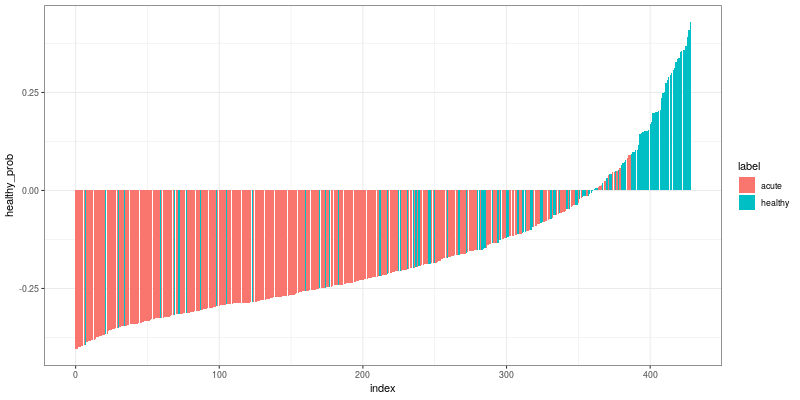

In [22]:
%%R -w 800 -h 400
a=read.csv("V_usage/AB_vs_HIP_freq_adjusted_1047_gamming_hold_out_diff_sets.tsv",sep="\t",header=TRUE)
ggplot(a,aes(x=index,y=healthy_prob,fill=label))+geom_col()+theme_bw()

In [ ]:
### 5.2) apply RF trained on Adaptive vs HIP to FMBA


In [36]:
X_to_fit = pd.concat([X_to_fit, X_hold_out])
y_to_fit = pd.concat([y_to_fit, y_hold_out])


In [37]:
adaptive_RF=RandomForestClassifier(class_weight="balanced",n_estimators=500,
                                       n_jobs=40,
                                          max_depth=5, max_features=50)


adaptive_RF.fit(X_to_fit, y_to_fit)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=40, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [26]:
FMBA_data=pd.read_csv("V_usage/FMBA_corr_functional_adjusted_frequencies_ALL_cac_hamming1.tsv",
                    sep="\t")
FMBA_data.index=[xT.split("_")[0] for xT in FMBA_data.index]

FMBA_metadata=pd.read_csv("/projects/fmba_covid/metadata_fmba_full_v2.txt",
                          sep="\t",header=0, dtype = str)
FMBA_metadata["sample.COVID_status"].value_counts()


current       821
healthy       409
suspicious     20
Name: sample.COVID_status, dtype: int64

In [27]:
#SUBSAMMPLE current or healthy
#USE ALL CURRENT do not split by IgG+/-
fmba_healthy=set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="healthy","CSP"])
fmba_current=set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="current","CSP"])
fmba_healthy_or_current_id=fmba_healthy|fmba_current

FMBA_data_healthy_or_current=FMBA_data.loc[set(FMBA_data.index.values)&fmba_healthy_or_current_id,
                                               HIP_data.columns[HIP_data.columns!="status"]]

#FMBA_data_healthy_or_current=FMBA_data_healthy_or_current.loc[set(FMBA_data_healthy_or_current.index.values)&
#                                                              (set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="healthy","CSP"])|
#                                                              set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_IgG"]=="yes","CSP"])),:]

FMBA_data_healthy_or_current["status"]="current"
FMBA_data_healthy_or_current.loc[set(FMBA_data_healthy_or_current.index.values)&fmba_healthy,"status"]="healthy"
FMBA_data_healthy_or_current["status"].value_counts()

current    519
healthy    302
Name: status, dtype: int64

In [28]:
X_fmba=FMBA_data_healthy_or_current[FMBA_data_healthy_or_current.columns[~FMBA_data_healthy_or_current.columns.isin(["status"])]]
y_fmba=list(FMBA_data_healthy_or_current["status"])



In [29]:
FMBA_data_healthy_or_current["status_M"]="COVID_IgM_Unknown"
FMBA_data_healthy_or_current.loc[set(FMBA_data_healthy_or_current.index.values)&
                             set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="current","CSP"])&
                             set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_IgM"]=="yes","CSP"]) ,"status_M"]="COVID_IgM+"
FMBA_data_healthy_or_current.loc[set(FMBA_data_healthy_or_current.index.values)&
                             set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="current","CSP"])&
                             set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_IgM"]=="no","CSP"]) ,"status_M"]="COVID_IgM-"
FMBA_data_healthy_or_current.loc[set(FMBA_data_healthy_or_current.index.values)&
                             set(FMBA_metadata.loc[FMBA_metadata["sample.COVID_status"]=="healthy","CSP"]) ,"status_M"]="healthy"


In [30]:
#change label to becomme like adaptive
y_fmba = ["acute" if y_t =="current"  else y_t for y_t in y_fmba]


In [38]:
#Apply Adaptive Tree to IgG+ and IgG- FMBA
y_fmba_predicted=adaptive_RF.predict(X_fmba)
acc = balanced_accuracy_score(y_fmba, y_fmba_predicted)
print(acc)
conf_mat = confusion_matrix(y_fmba, y_fmba_predicted)
print(conf_mat)


0.49852301292602946
[[502  17]
 [293   9]]


In [39]:
label_prob=adaptive_RF.predict_proba(X_fmba)
a=pd.DataFrame(label_prob)
a["label"]=list(y_fmba)
#a["label"]=list(FMBA_data_healthy_or_current["status_M"])
a["healthy_prob"]=a[1]-0.5
a=a.sort_values(by=['healthy_prob'])
a["index"]=range(len(list(y_fmba)))
a.to_csv("AB_prediction/AB_to_FMBA_freq_adj.tsv",sep="\t")

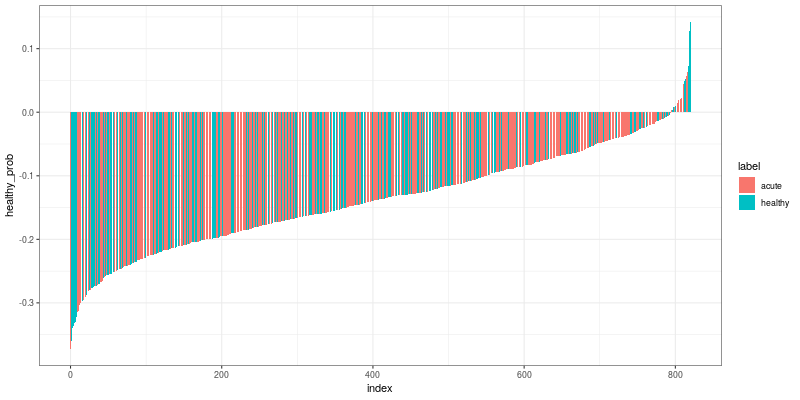

In [40]:
%%R -w 800 -h 400
#IgG+ and IgG-
a=read.csv("AB_prediction/AB_to_FMBA_freq_adj.tsv",sep="\t",header=TRUE)
ggplot(a,aes(x=index,y=healthy_prob,fill=label))+geom_col()+theme_bw()



In [78]:
FMBA_data_healthy_or_current.loc[FMBA_data_healthy_or_current["status"]=="current"].sum(axis=1).median()


0.086972778486156

In [79]:
FMBA_data_healthy_or_current.loc[FMBA_data_healthy_or_current["status"]=="healthy"].sum(axis=1).median()


0.05824829777898341

In [81]:
import seaborn as sns

In [80]:
plt.plot()

NameError: name 'plt' is not defined

In [44]:
FMBA_data_healthy_or_current.sum(axis=1).median()


0.07620383402565953

In [45]:
AB_data.sum(axis=1).median()


0.05050717754867416

In [46]:
HIP_data.sum(axis=1).median()


0.04516335290375511

In [53]:
HIP_data_scaled_to_one=HIP_data[HIP_data.columns[~HIP_data.columns.isin(["status"])]].div(HIP_data[HIP_data.columns[~HIP_data.columns.isin(["status"])]].sum(axis=1), axis=0)


In [54]:
HIP_data_scaled_to_one.sum(axis=1).median()

1.0

In [55]:
AB_data_scaled_to_one=AB_data[AB_data.columns[~AB_data.columns.isin(["status"])]].div(AB_data[AB_data.columns[~AB_data.columns.isin(["status"])]].sum(axis=1), axis=0)



In [58]:
FMBA_data_healthy_or_current_scaled_to_one=FMBA_data_healthy_or_current[FMBA_data_healthy_or_current.columns[~FMBA_data_healthy_or_current.columns.isin(["status","status_M"])]].div(FMBA_data_healthy_or_current[FMBA_data_healthy_or_current.columns[~FMBA_data_healthy_or_current.columns.isin(["status","status_M"])]].sum(axis=1), axis=0)



In [75]:
FMBA_data_healthy_or_current_scaled_to_one.head()


,CASSLGTGNSPLHF,CASSPGGNSPLHF,CASSLTGNSPLHF,CASSRGNSPLHF,CASSLGRNSPLHF,CASSLDRNSPLHF,CASSLAGNSPLHF,CASSSGQGNSPLHF,CASSLGQYNSPLHF,CASSPGQYNSPLHF,...,CASSPGTRGNTIYF,CASSLQRGNYGYTF,CASSLSGYNSPLHF,CASSLEIGEQFF,CASSLTGSRNQPQHF,CASSLGRPNSPLHF,CASSTQSSGNTIYF,CAWSLREKLFF,CASRTSGPSYNEQFF,status
270000060808,0.008108,0.000000,0.000000,0.000000,0.000000,0.000897,0.000000,0.008152,0.000000,0.001856,...,0.000000,0.0,0.00188,0.0,0.00000,0.000000,0.000000,0.0,0.0,healthy
780008300807,0.005787,0.000055,0.004872,0.000000,0.000022,0.001015,0.006625,0.005459,0.002695,0.002684,...,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.0,acute
690000120808,0.001001,0.000319,0.000319,0.000823,0.002855,0.002669,0.000319,0.002336,0.002161,0.000000,...,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.000000,0.0,0.0,acute
270000160807,0.000000,0.000000,0.000000,0.000000,0.000000,0.003020,0.000010,0.000000,0.003094,0.002215,...,0.000000,0.0,0.00000,0.0,0.00000,0.000003,0.002770,0.0,0.0,healthy
020000360808,0.004170,0.000572,0.001484,0.000991,0.000415,0.001484,0.003522,0.001968,0.003837,0.000000,...,0.000402,0.0,0.00000,0.0,0.00028,0.000000,0.000796,0.0,0.0,healthy


In [60]:
AB_data_scaled_to_one["status"]="acute"
HIP_data_scaled_to_one["status"]="healthy"

AB_and_HIP_data_scaled_to_one = pd.concat([AB_data_scaled_to_one, HIP_data_scaled_to_one])
X_to_fit=AB_and_HIP_data_scaled_to_one[AB_and_HIP_data_scaled_to_one.columns[~AB_and_HIP_data_scaled_to_one.columns.isin(["status"])]]
y_to_fit=AB_and_HIP_data_scaled_to_one["status"]


In [61]:
adaptive_RF_scaled_to_one=RandomForestClassifier(class_weight="balanced",n_estimators=500,
                                       n_jobs=40,
                                          max_depth=5, max_features=50)

adaptive_RF_scaled_to_one.fit(X_to_fit, y_to_fit)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=40, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [64]:
FMBA_data_healthy_or_current_scaled_to_one["status"]="acute"
FMBA_data_healthy_or_current_scaled_to_one.loc[set(FMBA_data_healthy_or_current_scaled_to_one.index.values)&fmba_healthy,"status"]="healthy"

X_fmba=FMBA_data_healthy_or_current_scaled_to_one[FMBA_data_healthy_or_current_scaled_to_one.columns[~FMBA_data_healthy_or_current_scaled_to_one.columns.isin(["status"])]]
y_fmba=list(FMBA_data_healthy_or_current_scaled_to_one["status"])


In [65]:
y_fmba_predicted=adaptive_RF_scaled_to_one.predict(X_fmba)
acc = balanced_accuracy_score(y_fmba, y_fmba_predicted)
print(acc)
conf_mat = confusion_matrix(y_fmba, y_fmba_predicted)
print(conf_mat)

0.5129738799780525
[[517   2]
 [293   9]]


In [71]:
label_prob=adaptive_RF_scaled_to_one.predict_proba(X_fmba)
a=pd.DataFrame(label_prob)
a["label"]=list(y_fmba)
#a["label"]=list(FMBA_data_healthy_or_current["status_M"])
a["healthy_prob"]=a[1]-0.5
a=a.sort_values(by=['healthy_prob'])
a["index"]=range(len(list(y_fmba)))
a.to_csv("AB_prediction/AB_to_FMBA_freq_adj_scaled.tsv",sep="\t")

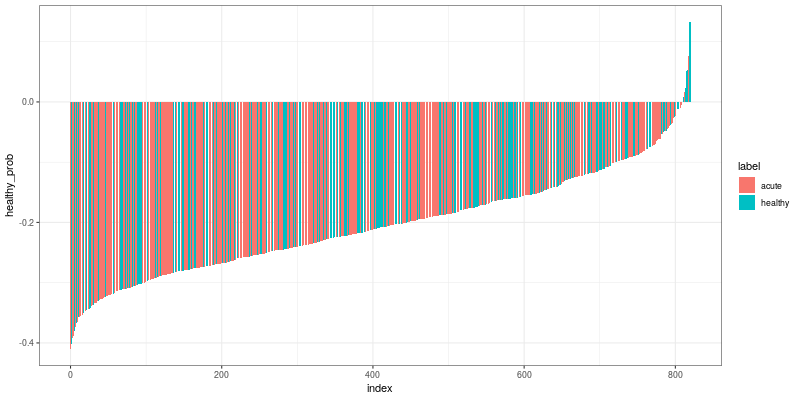

In [72]:
%%R -w 800 -h 400
#IgG+ and IgG-
a=read.csv("AB_prediction/AB_to_FMBA_freq_adj_scaled.tsv",sep="\t",header=TRUE)
ggplot(a,aes(x=index,y=healthy_prob,fill=label))+geom_col()+theme_bw()


In [197]:
clonoset=pd.read_csv("/home/taumata/COV_AdaptiveBiotech_v2/fmba_new_corr_TRB_func/630001520808_S117_L002.clonotypes.TRB.txt",
                    sep="\t")

In [201]:
clonoset.to_csv("/home/taumata/test",sep="\t", index=False)


In [82]:
FMBA_metadata=pd.read_csv("/projects/fmba_covid/metadata_fmba_full_v2.txt",
                          sep="\t",header=0)

print(FMBA_metadata["sample.COVID_status"].value_counts())
fmba_stats["short_name"]=[int(xT.split("_")[0]) for xT in fmba_stats["sample_id"]]
fmba_stats=fmba_stats.merge(FMBA_metadata, how='inner', left_on="short_name", right_on="CSP")

plt.boxplot([fmba_stats.loc[fmba_stats["sample.COVID_status"]=="healthy","passed_clones"],
             fmba_stats.loc[(fmba_stats["sample.COVID_status"]=="current") &
                            (fmba_stats["sample.COVID_IgG"]=="yes"),"passed_clones"],
             fmba_stats.loc[(fmba_stats["sample.COVID_status"]=="current") &
                            (fmba_stats["sample.COVID_IgG"]=="no"),"passed_clones"]],
           labels=["healthy","current_IgG+","current_IgG-"])

current       821
healthy       409
suspicious     20
Name: sample.COVID_status, dtype: int64


NameError: name 'fmba_stats' is not defined

In [ ]:
#copy columns with general metadata
fmba_colapse=fmba.loc[:,['sample_id', 'Dataset', 'passed_clones']]
#copy columns with TRBV that do not have subfamilies
v_colapse=pd.concat([fmba_colapse,
                           fmba.loc[:,[xT for xT in fmba.columns if xT.startswith("TRBV") & (re.search("-",xT)==None)]]], axis=1)
#sum all TRBV from different subfamilies of same family
for trbv in set([xT.split("-")[0] for xT in fmba.columns if xT.startswith("TRBV") & (re.search("-",xT)!=None)]):
    #print(trbv)
    #print(hip_keck.loc[:,[xT for xT in hip_keck.columns if re.search(str(trbv)+"-",xT)!=None]].columns)
    fmba_colapse[trbv]=fmba.loc[:,[xT for xT in fmba.columns if re.search(str(trbv)+"-",xT)!=None]].sum(axis=1)
 

# Get "golden standart" for V-J frequencies from Walczak:
https://raw.githubusercontent.com/qmarcou/IGoR/master/models/human/tcr_beta/models/model_parms.txt
https://raw.githubusercontent.com/qmarcou/IGoR/master/models/human/tcr_beta/models/model_marginals.txt

In [4]:
try:
    os.mkdir("V_J_usage_Walczak")
except:
    pass

### Download recombination model

In [5]:
download_command="wget -O V_J_usage_Walczak/model_parms.txt \
            https://raw.githubusercontent.com/qmarcou/IGoR/master/models/human/tcr_beta/models/model_parms.txt"
os.system(download_command)


0

In [6]:
download_command="wget -O V_J_usage_Walczak/model_marginals.txt \
            https://raw.githubusercontent.com/qmarcou/IGoR/master/models/human/tcr_beta/models/model_marginals.txt"
os.system(download_command)

0

### Read model parametrs

In [82]:
#Read gene names
v_gene_code_to_names={}
v_gene_names_to_code={}

j_gene_code_to_names={}
j_gene_names_to_code={}
with open("V_J_usage_Walczak/model_parms.txt","r") as model_params:
    for line in model_params:
        if re.search("V-REGION",line):
            splited_line=line.strip().split(";")
            v_gene_code_number=splited_line[-1]
            v_gene_name=splited_line[0].split("|")[1]
            v_gene_code_to_names[v_gene_code_number]=v_gene_name
            v_gene_names_to_code[v_gene_name]=v_gene_code_number
            
        elif re.search("J-REGION",line):
            splited_line=line.strip().split(";")
            j_gene_code_number=splited_line[-1]
            j_gene_name=splited_line[0].split("|")[1]
            j_gene_code_to_names[j_gene_code_number]=j_gene_name
            j_gene_names_to_code[j_gene_name]=j_gene_code_number
            

In [83]:
#read v and v-j frequencies
v_usage={}
j_usage={}
v_j_usage={}

with open("V_J_usage_Walczak/model_marginals.txt","r") as model_marginals:
    for line in model_marginals:
        if line.startswith("@v_choice"):
            model_marginals.readline() #skip two lines
            model_marginals.readline()
            v_usage_raw=model_marginals.readline() #read third line
            v_usage_raw=v_usage_raw[1:] #skip first element "%"
            v_usage_raw=v_usage_raw.strip().split(",")
            for v_count, v_gene_freq in enumerate(v_usage_raw):
                v_usage[v_count]=float(v_gene_freq)
        elif re.search("\[v_choice",line):
            v_gene_code=re.search("v_choice,(\d+)\]",line).group(1) #extract v_gene_code from line in format [v_choice,v_gene_code]
            j_usage_raw=model_marginals.readline()
            j_usage_raw=j_usage_raw[1:] #skip first element "%"
            j_usage_raw=j_usage_raw.strip().split(",")
            v_j_usage[v_gene_code]={}
            for j_count, j_gene_freq in enumerate(j_usage_raw):
                if j_count not in j_usage:
                    j_usage[j_count]=0
                j_usage[j_count]+=float(j_gene_freq)
                v_j_usage[v_gene_code][j_count]=float(j_gene_freq)

            



In [ ]:
#read TRBV names

In [89]:
counter=0
TRBV_codes_to_names={}
with open("V_J_usage_Walczak/model_parms.txt","r") as model_parms:
    for line in model_parms:
        if re.search("V-REGION",line):
            gene_name=re.search("(TRBV\d+)",line).group(1)
            TRBV_codes_to_names[counter]=gene_name
            counter+=1
print(TRBV_codes_to_names)


{0: 'TRBV9', 1: 'TRBV7', 2: 'TRBV7', 3: 'TRBV7', 4: 'TRBV7', 5: 'TRBV7', 6: 'TRBV7', 7: 'TRBV7', 8: 'TRBV6', 9: 'TRBV6', 10: 'TRBV7', 11: 'TRBV6', 12: 'TRBV7', 13: 'TRBV6', 14: 'TRBV6', 15: 'TRBV6', 16: 'TRBV5', 17: 'TRBV5', 18: 'TRBV5', 19: 'TRBV5', 20: 'TRBV7', 21: 'TRBV5', 22: 'TRBV5', 23: 'TRBV5', 24: 'TRBV4', 25: 'TRBV6', 26: 'TRBV4', 27: 'TRBV4', 28: 'TRBV30', 29: 'TRBV6', 30: 'TRBV15', 31: 'TRBV2', 32: 'TRBV13', 33: 'TRBV7', 34: 'TRBV11', 35: 'TRBV7', 36: 'TRBV12', 37: 'TRBV11', 38: 'TRBV12', 39: 'TRBV5', 40: 'TRBV11', 41: 'TRBV19', 42: 'TRBV7', 43: 'TRBV7', 44: 'TRBV1', 45: 'TRBV10', 46: 'TRBV12', 47: 'TRBV26', 48: 'TRBV7', 49: 'TRBV4', 50: 'TRBV10', 51: 'TRBV10', 52: 'TRBV3', 53: 'TRBV6', 54: 'TRBV30', 55: 'TRBV10', 56: 'TRBV12', 57: 'TRBV12', 58: 'TRBV15', 59: 'TRBV10', 60: 'TRBV30', 61: 'TRBV6', 62: 'TRBV12', 63: 'TRBV23', 64: 'TRBV10', 65: 'TRBV7', 66: 'TRBV7', 67: 'TRBV14', 68: 'TRBV11', 69: 'TRBV15', 70: 'TRBV29', 71: 'TRBV16', 72: 'TRBV18', 73: 'TRBV7', 74: 'TRBV17', 75:

In [ ]:
#collapse different alleles

In [90]:
v_usage_golden={}
for v_segment_code in v_usage:
    if TRBV_codes_to_names[v_segment_code] not in v_usage_golden:
        v_usage_golden[TRBV_codes_to_names[v_segment_code]]=0
    v_usage_golden[TRBV_codes_to_names[v_segment_code]]+=v_usage[v_segment_code]
    

In [91]:
v_usage_golden

{'TRBV9': 0.00488741,
 'TRBV7': 0.17819048299999996,
 'TRBV6': 0.2633601189,
 'TRBV5': 0.0595948082,
 'TRBV4': 0.13024818999999999,
 'TRBV30': 0.0212701,
 'TRBV15': 0.09450986,
 'TRBV2': 0.030002300000000003,
 'TRBV13': 0.000736226,
 'TRBV11': 0.0227343375,
 'TRBV12': 0.040389089,
 'TRBV19': 0.00245219,
 'TRBV1': 0.00298804,
 'TRBV10': 0.06458757999999999,
 'TRBV26': 0.00906711,
 'TRBV3': 0.03117879,
 'TRBV23': 0.00419227,
 'TRBV14': 1.29795e-07,
 'TRBV29': 0.02274081,
 'TRBV16': 0.0,
 'TRBV18': 0.00391595,
 'TRBV17': 0.0,
 'TRBV20': 6.73805e-05,
 'TRBV27': 0.00818432,
 'TRBV24': 0.00107035,
 'TRBV28': 0.000364764,
 'TRBV25': 0.0032679}